In [1]:
# Sanity check for Python version in this Notebook kernel
import sys
print(sys.version)
assert sys.version_info >= (3, 10), "Use the Python 3.11 (.venv311) kernel for sentence-transformers>=5.x"


3.11.14 (main, Oct  9 2025, 16:16:55) [Clang 17.0.0 (clang-1700.0.13.3)]


In [2]:
# --- Utilities: text sanity checks + prediction helpers ---

def sanity_check_texts(df, text_col="text", max_preview=3):
    """
    Basic input QA: existence of text column, empties, basic stats.
    """
    assert text_col in df.columns, f"Missing required column: '{text_col}'"
    n = len(df)
    n_empty = df[text_col].astype(str).str.strip().eq("").sum()
    avg_len = df[text_col].astype(str).str.len().mean()
    print(f"Rows: {n} | Empty rows: {n_empty} ({n_empty/n:.1%}) | Avg length: {avg_len:.1f}")
    print("Preview:", df[text_col].head(max_preview).tolist())

def predict_batch_text(df, text_col="text"):
    """
    Predict labels for a DataFrame with a 'text' column.
    Returns a copy with an added 'pred_label' column.
    """
    X = df[[text_col]].rename(columns={text_col: "text"})
    preds = model.predict(X)
    out = df.copy()
    out["pred_label"] = preds
    return out

def top2_margin(X_df, k=2):
    """
    Compute decision-function margins (confidence proxy) for LinearSVC.
    Returns:
      - top_pred: predicted class (string)
      - margin: gap between top1 and top2 scores (float; larger = more confident)
    """
    X = X_df[["text"]]
    dec = model.decision_function(X)               # shape: [n_samples, n_classes]
    top2_idx = np.argsort(dec, axis=1)[:, -k:]     # indices of top-2 classes
    top_scores = np.take_along_axis(dec, top2_idx, axis=1)
    margin = top_scores[:, 1] - top_scores[:, 0]   # top1 - top2 after sort of last two
    # Actually we sorted ascending; swap to ensure positive margin
    margin = margin.clip(min=0)
    top1_index = np.argmax(dec, axis=1)
    top_pred = labels[top1_index]
    return top_pred, margin


In [4]:
# --- Unlabeled batch inference (robust path handling) ---

import os
from pathlib import Path
import pandas as pd
from datetime import datetime

# 1) Point to your input CSV. It must have a 'text' column.
#    Change this path to your real file if you already have one.
INPUT_CSV = Path("../data/inference/new_reviews.csv")

# 2) Output path
os.makedirs("outputs", exist_ok=True)
OUTPUT_CSV = Path(f"outputs/predictions_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv")

# 3) If the input file doesn't exist, create a small demo file so the pipeline can run end-to-end.
if not INPUT_CSV.exists():
    print(f"⚠️  Input not found: {INPUT_CSV.resolve()}")
    demo_dir = Path("../data/inference")
    demo_dir.mkdir(parents=True, exist_ok=True)
    INPUT_CSV = demo_dir / "new_reviews_demo.csv"
    demo_df = pd.DataFrame({
        "text": [
            "This review contains threatening language and offensive words.",
            "Marketing-only content about discounts and promotions.",
            "Posted by someone affiliated with the community staff.",
            "Completely unrelated to the property, off-topic rant.",
            "Likely a competitor mentioning prices and other brand names."
        ]
    })
    demo_df.to_csv(INPUT_CSV, index=False)
    print(f"✅ Created demo file at: {INPUT_CSV.resolve()}")

# 4) Load, sanity-check, predict, and save
df_infer = pd.read_csv(INPUT_CSV)
sanity_check_texts(df_infer, text_col="text")

# Predictions
pred_df = predict_batch_text(df_infer, text_col="text")

# Optional: decision-function top-2 margin as a simple confidence proxy
Xtmp = pred_df[["text"]].rename(columns={"text": "text"})
top_pred, margin = top2_margin(Xtmp, k=2)
pred_df["pred_label"] = top_pred
pred_df["margin_top2"] = margin

pred_df.to_csv(OUTPUT_CSV, index=False)
print(f"✅ Saved predictions to: {OUTPUT_CSV.resolve()}")

# Show a small preview
pred_df.head(10)


⚠️  Input not found: /Users/tiffanytseng/Documents/ai-review-moderation/data/inference/new_reviews.csv
✅ Created demo file at: /Users/tiffanytseng/Documents/ai-review-moderation/data/inference/new_reviews_demo.csv
Rows: 5 | Empty rows: 0 (0.0%) | Avg length: 56.6
Preview: ['This review contains threatening language and offensive words.', 'Marketing-only content about discounts and promotions.', 'Posted by someone affiliated with the community staff.']
✅ Saved predictions to: /Users/tiffanytseng/Documents/ai-review-moderation/notebooks/outputs/predictions_20251014_173318.csv


,text,pred_label,margin_top2
0,This review contains threatening language and ...,"It was posted by a competitor, ex-employee or ...",0.020200
1,Marketing-only content about discounts and pro...,It contains promotional materials,0.234344
2,Posted by someone affiliated with the communit...,It was posted by someone affiliated with the c...,0.055304
3,"Completely unrelated to the property, off-topi...",It contains irrelevant information that is not...,0.026380
4,Likely a competitor mentioning prices and othe...,It's for the wrong community,0.158937


In [5]:
# --- Labeled evaluation (pre-deployment checks) ---
# If you have a labeled CSV with columns: 'text' (input) and 'label' (ground-truth),
# set EVAL_CSV below; otherwise skip this cell.

EVAL_CSV = "../data/inference/eval_reviews_labeled.csv"  # change as needed
REPORT_DIR = "reports"
os.makedirs(REPORT_DIR, exist_ok=True)

if os.path.exists(EVAL_CSV):
    eval_df = pd.read_csv(EVAL_CSV)
    assert {"text", "label"}.issubset(eval_df.columns), "CSV must have 'text' and 'label'."
    print("✅ Labeled file found. Running evaluation...")
    sanity_check_texts(eval_df, text_col="text")

    # Predict
    X_eval = eval_df[["text"]].rename(columns={"text": "text"})
    y_true = eval_df["label"].astype(str).values
    y_pred = model.predict(X_eval)

    # Metrics
    print("\n=== Classification report (zero_division=0) ===")
    print(classification_report(y_true, y_pred, zero_division=0))
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    weighted_f1 = f1_score(y_true, y_pred, average="weighted")
    print("macro F1:", round(macro_f1, 4))
    print("weighted F1:", round(weighted_f1, 4))

    # Save report as CSV
    report_dict = classification_report(y_true, y_pred, zero_division=0, output_dict=True)
    report_df = pd.DataFrame(report_dict).T
    report_csv = os.path.join(REPORT_DIR, f"classification_report_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv")
    report_df.to_csv(report_csv)
    print(f"Saved classification report CSV to: {report_csv}")

    # Confusion matrix (PNG)
    fig = plt.figure(figsize=(11, 9))
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, xticks_rotation=90)
    plt.title("Confusion Matrix — Eval Set")
    plt.tight_layout()
    cm_png = os.path.join(REPORT_DIR, f"confusion_matrix_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png")
    plt.savefig(cm_png, dpi=200)
    plt.show()
    print(f"Saved confusion matrix PNG to: {cm_png}")

else:
    print("⚠️ Labeled eval CSV not found. Skipping evaluation.")


⚠️ Labeled eval CSV not found. Skipping evaluation.


In [7]:
# --- Error analysis (optional but recommended) ---

# 1) Flag low-confidence predictions by margin (on the unlabeled batch we just scored)
if 'pred_df' in globals():
    threshold = np.percentile(pred_df["margin_top2"], 20)  # bottom 20% margins
    low_conf = pred_df[pred_df["margin_top2"] <= threshold].copy()
    low_conf_csv = os.path.join(REPORT_DIR, f"low_confidence_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv")
    low_conf.to_csv(low_conf_csv, index=False)
    print(f"Saved low-confidence subset to: {low_conf_csv} (threshold={threshold:.4f}, count={len(low_conf)})")
else:
    print("No 'pred_df' in scope — run the unlabeled batch cell first.")

# 2) If evaluation is available, list most common confusion pairs
if 'eval_df' in globals() and os.path.exists(EVAL_CSV):
    from collections import Counter
    pairs = Counter(zip(eval_df["label"].astype(str).values, model.predict(eval_df[["text"]])))
    most_confused = sorted([(a,b,c) for (a,b), c in pairs.items() if a!=b], key=lambda x: x[2], reverse=True)[:10]
    print("\nTop confusion pairs (true -> pred -> count):")
    for a,b,c in most_confused:
        print(f"{a}  ->  {b}  : {c}")


Saved low-confidence subset to: reports/low_confidence_20251014_173438.csv (threshold=0.0251, count=1)


In [8]:
# --- Simple batch function (for later serving integration) ---

def serve_batch(json_payload, text_key="text"):
    """
    Emulates a minimal REST handler for batch inference.
    json_payload: list[dict] with key 'text' (or custom via text_key)
    Returns: list[dict] with 'pred_label' (and 'margin' for ranking)
    """
    import pandas as pd
    assert isinstance(json_payload, list), "json_payload should be a list of dicts"
    df = pd.DataFrame(json_payload)
    assert text_key in df.columns, f"Missing '{text_key}' in payload items"
    df = df.rename(columns={text_key: "text"})

    preds = model.predict(df[["text"]])
    # margin proxy
    top_pred, margin = top2_margin(df[["text"]], k=2)
    return [
        {"pred_label": p, "margin": float(m)}
        for p, m in zip(top_pred, margin)
    ]

# Demo
serve_batch([
    {"text": "This review contains threatening language and offensive words."},
    {"text": "Marketing-only content about discounts and promotions."},
    {"text": "This seems to be posted by a competitor, not a real resident."}
])


[{'pred_label': 'It was posted by a competitor, ex-employee or evicted resident',
  'margin': 0.020199547924281025},
 {'pred_label': 'It contains promotional materials',
  'margin': 0.23434410618876922},
 {'pred_label': 'It was posted by someone affiliated with the community',
  'margin': 0.057160138367897795}]

In [9]:
# --- Export a compact README for this run ---

readme_txt = f"""\
Run timestamp: {datetime.now().isoformat(timespec='seconds')}
Model path: {MODEL_PATH}
Labels path: {LABELS_PATH}
Num labels: {len(labels)}
Notes:
- Character-level TF-IDF + LinearSVC pipeline loaded from artifacts.
- Batch inference expects a CSV with a 'text' column.
- If labeled CSV is provided, we compute classification report and confusion matrix.
- We also save low-confidence cases (by top-2 margin) for human review.
"""

readme_path = os.path.join(REPORT_DIR, f"README_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt")
with open(readme_path, "w") as f:
    f.write(readme_txt)

print(f"Saved README to: {readme_path}")


Saved README to: reports/README_20251014_173459.txt


Inference-only mode: no ground-truth labels found.
Preview of predictions:
                                                text  \
0  This review contains threatening language and ...   
1  Marketing-only content about discounts and pro...   
2  Posted by someone affiliated with the communit...   
3  Completely unrelated to the property, off-topi...   
4  Likely a competitor mentioning prices and othe...   

                                          pred_label  margin_top2  
0  It was posted by a competitor, ex-employee or ...     0.020200  
1                  It contains promotional materials     0.234344  
2  It was posted by someone affiliated with the c...     0.055304  
3  It contains irrelevant information that is not...     0.026380  
4                       It's for the wrong community     0.158937  


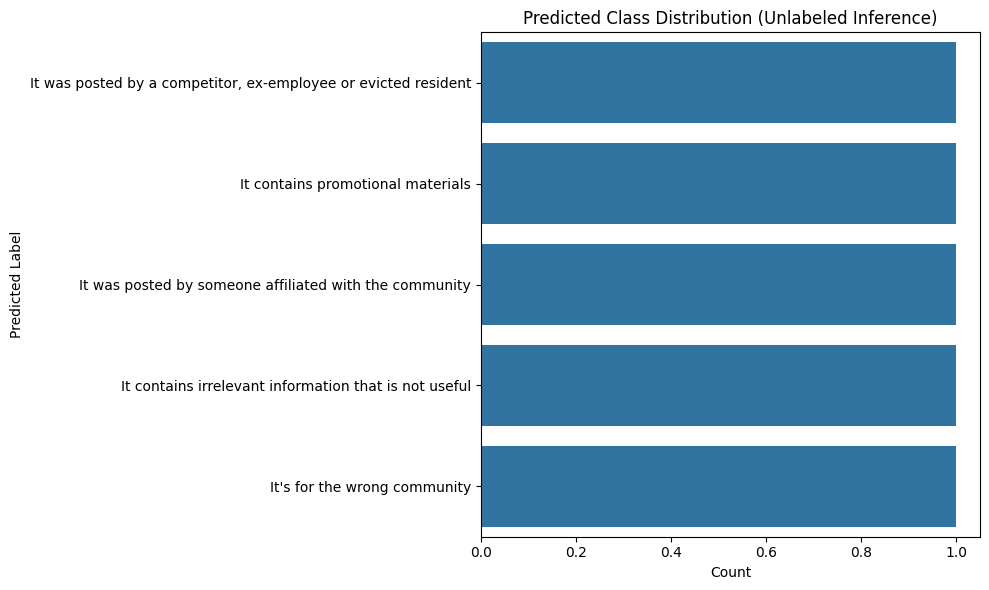

Saved: outputs/predicted_class_distribution.png
Done.


In [11]:
# --- Auto-detect evaluation vs. pure inference and export visuals/metrics ---
# Place this cell AFTER you have created `pred_df` (i.e., after batch predictions).
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 0) Preconditions and setup
assert "pred_df" in globals(), "`pred_df` not found. Run the batch prediction cell first."
os.makedirs("outputs", exist_ok=True)

# We try to locate true labels in df_infer if available.
# Adjust `CANDIDATE_LABEL_COLS` if your true-label column has a different name.
CANDIDATE_LABEL_COLS = ["true_label", "label", "reason_fixed", "reason"]
has_df_infer = "df_infer" in globals() and isinstance(df_infer, pd.DataFrame)
true_label_col = None
if has_df_infer:
    for c in CANDIDATE_LABEL_COLS:
        if c in df_infer.columns:
            true_label_col = c
            break

# 1) If no true labels: summarize predictions only (pure inference mode)
if not has_df_infer or true_label_col is None:
    print("Inference-only mode: no ground-truth labels found.")
    print("Preview of predictions:")
    print(pred_df.head())

    # Class distribution of predictions
    plt.figure(figsize=(10, 6))
    order = pred_df["pred_label"].value_counts().index
    sns.countplot(y=pred_df["pred_label"], order=order)
    plt.title("Predicted Class Distribution (Unlabeled Inference)")
    plt.xlabel("Count")
    plt.ylabel("Predicted Label")
    plt.tight_layout()
    plt.savefig("outputs/predicted_class_distribution.png")
    plt.show()
    print("Saved: outputs/predicted_class_distribution.png")

# 2) If true labels exist: full evaluation (classification_report + confusion matrix)
else:
    print(f"Evaluation mode: found ground-truth column '{true_label_col}'.")
    # Align y_true with the same rows used for prediction.
    # If your pipeline filtered rows earlier, ensure the same subset/order is used.
    # Here we assume df_infer corresponds row-by-row to pred_df.
    y_true = df_infer[true_label_col].astype(str).reset_index(drop=True)
    y_pred = pred_df["pred_label"].astype(str).reset_index(drop=True)

    # Make sure lengths match (if not, try to align by index intersection)
    if len(y_true) != len(y_pred):
        common_len = min(len(y_true), len(y_pred))
        y_true = y_true.iloc[:common_len].reset_index(drop=True)
        y_pred = y_pred.iloc[:common_len].reset_index(drop=True)
        print(f"Warning: y_true and y_pred length mismatch; truncated to {common_len} rows.")

    # Classification report (print + save txt/csv)
    report_txt = classification_report(y_true, y_pred, zero_division=0)
    print(report_txt)

    # Save as text
    with open("outputs/classification_report.txt", "w") as f:
        f.write(report_txt)
    print("Saved: outputs/classification_report.txt")

    # Save as CSV (structured)
    report_dict = classification_report(y_true, y_pred, zero_division=0, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()
    report_df.to_csv("outputs/classification_report.csv")
    print("Saved: outputs/classification_report.csv")

    # Confusion matrix with stable label order (union of seen labels)
    labels = sorted(set(y_true.unique()).union(set(y_pred.unique())))
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    plt.figure(figsize=(12, 9))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig("outputs/confusion_matrix.png")
    plt.show()
    print("Saved: outputs/confusion_matrix.png")

print("Done.")


In [13]:
# --- Build a low-confidence review queue with Top-K candidates (robust to feature set) ---
# Paste this cell AFTER you have created `pred_df` (and `df_infer` if available).

import os
import numpy as np
import pandas as pd
import joblib
import re, string

# Small helpers to reconstruct numeric features (must match training logic)
PUNCT = set(string.punctuation)

def count_upper_words(text: str) -> int:
    return sum(1 for w in re.findall(r"[A-Za-z]{2,}", str(text)) if w.isupper())

def count_exclamation(text: str) -> int:
    return str(text).count("!")

def count_punctuation(text: str) -> int:
    return sum(1 for ch in str(text) if ch in PUNCT)

# 0) Load the saved pipeline and its class list
mdl = joblib.load("artifacts/model_char_svm.pkl")
classes = mdl.named_steps["clf"].classes_

# 1) Collect raw texts (prefer df_infer, fall back to pred_df)
if "df_infer" in globals() and isinstance(df_infer, pd.DataFrame):
    base_texts = df_infer["text"].astype(str).reset_index(drop=True)
else:
    base_texts = pred_df["text"].astype(str).reset_index(drop=True)

# 2) Build an input DataFrame with ALL columns possibly expected by the pipeline.
#    If the pipeline uses only 'text', extra columns will be ignored by ColumnTransformer.
X_features = pd.DataFrame({
    "text": base_texts,
})
# Add numeric features to satisfy pipelines that expect them
X_features["text_len"]    = X_features["text"].str.len()
X_features["upper_words"] = X_features["text"].apply(count_upper_words)
X_features["exclamation"] = X_features["text"].apply(count_exclamation)
X_features["punctuation"] = X_features["text"].apply(count_punctuation)

# 3) Get raw decision scores (n_samples x n_classes)
scores = mdl.decision_function(X_features)

# 4) Compute Top-3 labels and their scores
topk = 3
topk_idx = np.argsort(scores, axis=1)[:, -topk:][:, ::-1]   # descending
topk_labels = classes[topk_idx]
topk_scores = np.take_along_axis(scores, topk_idx, axis=1)

# 5) Attach Top-3 info to pred_df
out = pred_df.copy()
for k in range(topk):
    out[f"top{k+1}_label"] = topk_labels[:, k]
    out[f"top{k+1}_score"] = topk_scores[:, k]

# 6) Margin between Top1 and Top2 (uncertainty proxy)
if "margin_top2" not in out.columns:
    out["margin_top2"] = out["top1_score"] - out["top2_score"]

# 7) Export full predictions and a low-confidence review queue
THRESHOLD = 0.10  # tune this as you like
review_df = out[out["margin_top2"] < THRESHOLD].copy()

os.makedirs("outputs", exist_ok=True)
out_path_all   = "outputs/predictions_with_topk.csv"
out_path_queue = f"outputs/review_queue_margin_lt_{THRESHOLD:.2f}.csv"

out.to_csv(out_path_all, index=False)
review_df.to_csv(out_path_queue, index=False)

print(f"Saved full predictions with Top-K to: {out_path_all}")
print(f"Saved low-confidence review queue to: {out_path_queue}")
print(f"#low-confidence rows: {len(review_df)} / {len(out)} (threshold={THRESHOLD})")

out.head()


Saved full predictions with Top-K to: outputs/predictions_with_topk.csv
Saved low-confidence review queue to: outputs/review_queue_margin_lt_0.10.csv
#low-confidence rows: 3 / 5 (threshold=0.1)


,text,pred_label,margin_top2,top1_label,top1_score,top2_label,top2_score,top3_label,top3_score
0,This review contains threatening language and ...,"It was posted by a competitor, ex-employee or ...",0.020200,"It was posted by a competitor, ex-employee or ...",-0.418835,It contains promotional materials,-0.439035,It violates ApartmentRatings' privacy standards,-0.615317
1,Marketing-only content about discounts and pro...,It contains promotional materials,0.234344,It contains promotional materials,-0.063778,It contains false information,-0.298122,It's for the wrong community,-0.363303
2,Posted by someone affiliated with the communit...,It was posted by someone affiliated with the c...,0.055304,It was posted by someone affiliated with the c...,-0.660192,"It contains threats, lewdness or hate speech",-0.715496,It contains false information,-0.797901
3,"Completely unrelated to the property, off-topi...",It contains irrelevant information that is not...,0.026380,It contains irrelevant information that is not...,-0.316837,"It contains threats, lewdness or hate speech",-0.343217,It contains false information,-0.523571
4,Likely a competitor mentioning prices and othe...,It's for the wrong community,0.158937,It's for the wrong community,-0.202999,It was posted by someone affiliated with the c...,-0.361936,It contains irrelevant information that is not...,-0.505163


In [14]:
# --- Split predictions into auto-accept vs. human-review by margin threshold ---
import pandas as pd
import os

THRESHOLD = 0.15  # try 0.10~0.25 depending on your risk tolerance

df = pd.read_csv("outputs/predictions_with_topk.csv")
auto_accept = df[df["margin_top2"] >= THRESHOLD].copy()
review = df[df["margin_top2"] < THRESHOLD].copy()

os.makedirs("outputs", exist_ok=True)
auto_accept.to_csv(f"outputs/auto_accept_margin_ge_{THRESHOLD:.2f}.csv", index=False)
review.to_csv(f"outputs/review_queue_margin_lt_{THRESHOLD:.2f}.csv", index=False)

print(f"Auto-accept: {len(auto_accept)} rows")
print(f"Human-review: {len(review)} rows")
auto_accept.head()


Auto-accept: 2 rows
Human-review: 3 rows


,text,pred_label,margin_top2,top1_label,top1_score,top2_label,top2_score,top3_label,top3_score
1,Marketing-only content about discounts and pro...,It contains promotional materials,0.234344,It contains promotional materials,-0.063778,It contains false information,-0.298122,It's for the wrong community,-0.363303
4,Likely a competitor mentioning prices and othe...,It's for the wrong community,0.158937,It's for the wrong community,-0.202999,It was posted by someone affiliated with the c...,-0.361936,It contains irrelevant information that is not...,-0.505163


In [15]:
# --- Export an annotation-ready CSV (lightweight) ---
cols = [
    "text",
    "pred_label",
    "margin_top2",
    "top1_label","top1_score",
    "top2_label","top2_score",
    "top3_label","top3_score"
]
ann = review[cols].copy()
ann.insert(1, "gold_label", "")  # empty column for human to fill
ann.to_csv("outputs/review_queue_annotation_template.csv", index=False)
print("Saved: outputs/review_queue_annotation_template.csv")
ann.head()


Saved: outputs/review_queue_annotation_template.csv


,text,gold_label,pred_label,margin_top2,top1_label,top1_score,top2_label,top2_score,top3_label,top3_score
0,This review contains threatening language and ...,,"It was posted by a competitor, ex-employee or ...",0.020200,"It was posted by a competitor, ex-employee or ...",-0.418835,It contains promotional materials,-0.439035,It violates ApartmentRatings' privacy standards,-0.615317
2,Posted by someone affiliated with the communit...,,It was posted by someone affiliated with the c...,0.055304,It was posted by someone affiliated with the c...,-0.660192,"It contains threats, lewdness or hate speech",-0.715496,It contains false information,-0.797901
3,"Completely unrelated to the property, off-topi...",,It contains irrelevant information that is not...,0.026380,It contains irrelevant information that is not...,-0.316837,"It contains threats, lewdness or hate speech",-0.343217,It contains false information,-0.523571


In [20]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

textc = Pipeline([
    ("tfidf", TfidfVectorizer(analyzer="char", ngram_range=(3,5), max_features=40000))
])

pre = ColumnTransformer([
    ("textc", textc, "text"),
], remainder="drop")

svm_char = Pipeline([
    ("pre", pre),
    ("clf", LinearSVC(C=1.0))
])


In [32]:
import sys
!{sys.executable} -m pip install fastapi uvicorn pydantic


Defaulting to user installation because normal site-packages is not writeable
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [fastapi]


In [36]:
# --- Recreate train/test split before calibration ---
import pandas as pd
from sklearn.model_selection import train_test_split

# 1️⃣ Load your cleaned dataset
df = pd.read_csv("../data/processed/reported_reviews_clean.csv")

# 2️⃣ Drop NaN or empty text/label rows
df = df.dropna(subset=["review_text", "reason"])
df = df[df["review_text"].str.strip() != ""]
df = df[df["reason"].str.strip() != ""]

# 3️⃣ If text_len missing, rebuild it
if "text_len" not in df.columns:
    df["text_len"] = df["review_text"].str.len()

# 4️⃣ Keep only classes that appear >= 2 times (for stratify)
vc = df["reason"].value_counts()
df = df[df["reason"].isin(vc[vc >= 2].index)]

# 5️⃣ Prepare X and y
X = df[["review_text", "text_len"]].rename(columns={"review_text": "text"})
y = df["reason"]

# 6️⃣ Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("✅ Train/test split recreated successfully")
print("X_train:", X_train.shape, " | X_test:", X_test.shape)


✅ Train/test split recreated successfully
X_train: (25744, 2)  | X_test: (6436, 2)


In [40]:
# --- OPTIONAL: fit a calibrated SVM for probability outputs (sigmoid) ---
# This wraps your LinearSVC with CalibratedClassifierCV so you can call predict_proba.
# Requirements: variables `svm_char`, `X_train`, `y_train` are available.

from sklearn.calibration import CalibratedClassifierCV
from sklearn.base import clone
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import joblib

# 0) Safety checks
assert "svm_char" in globals(), "svm_char pipeline not found."
assert "X_train" in globals() and "y_train" in globals(), "Train split not found."

# 1) Make sure the char-level pipeline has the best params you used before
svm_char.set_params(
    clf__C=1.0,
    pre__textc__tfidf__max_features=40000,
    pre__textc__tfidf__ngram_range=(3, 5),
)

# 2) Build a new pipeline where the final step is a calibrated classifier
#    NOTE: scikit-learn >= 1.5 uses `estimator=` (NOT `base_estimator=`)
pre = svm_char.named_steps["pre"]
base = clone(svm_char.named_steps["clf"])  # LinearSVC clone

calibrated_pipe = Pipeline([
    ("pre", pre),
    ("clf", CalibratedClassifierCV(estimator=base, method="sigmoid", cv=3))
])

# 3) Fit on the training split
calibrated_pipe.fit(X_train, y_train)

# 4) Persist the calibrated model
out_path = "artifacts/model_char_svm_calibrated.pkl"
joblib.dump(calibrated_pipe, out_path)
print(f"Saved calibrated model to: {out_path}")

# 5) Tiny smoke test: get probabilities for a few samples
demo = pd.DataFrame({
    "text": [
        "This review contains threatening language and offensive words.",
        "Marketing-only content about discounts and promotions.",
        "This seems to be posted by a competitor, not a real resident."
    ]
})
probs = calibrated_pipe.predict_proba(demo)  # shape [n, n_classes]
labels = calibrated_pipe.named_steps["clf"].classes_
top1_idx = np.argmax(probs, axis=1)
print("Demo top-1 predictions:", [labels[i] for i in top1_idx])
print("Demo top-1 probs:", probs[np.arange(len(demo)), top1_idx])


/Users/tiffanytseng/Library/Python/3.9/lib/python/site-packages/sklearn/calibration.py:849: RuntimeWarning: divide by zero encountered in matmul
  grad = np.asarray([-g @ F, -g.sum()], dtype=np.float64)
/Users/tiffanytseng/Library/Python/3.9/lib/python/site-packages/sklearn/calibration.py:849: RuntimeWarning: overflow encountered in matmul
  grad = np.asarray([-g @ F, -g.sum()], dtype=np.float64)
/Users/tiffanytseng/Library/Python/3.9/lib/python/site-packages/sklearn/calibration.py:849: RuntimeWarning: invalid value encountered in matmul
  grad = np.asarray([-g @ F, -g.sum()], dtype=np.float64)
/Users/tiffanytseng/Library/Python/3.9/lib/python/site-packages/sklearn/calibration.py:849: RuntimeWarning: divide by zero encountered in matmul
  grad = np.asarray([-g @ F, -g.sum()], dtype=np.float64)
/Users/tiffanytseng/Library/Python/3.9/lib/python/site-packages/sklearn/calibration.py:849: RuntimeWarning: overflow encountered in matmul
  grad = np.asarray([-g @ F, -g.sum()], dtype=np.float64

Saved calibrated model to: artifacts/model_char_svm_calibrated.pkl
Demo top-1 predictions: ['It was posted by a competitor, ex-employee or evicted resident', 'It contains false information', 'It was posted by a competitor, ex-employee or evicted resident']
Demo top-1 probs: [0.3343476  0.35200588 0.31771377]


In [38]:
# --- Calibrate LinearSVC safely (sigmoid Platt scaling, stable setup) ---
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.pipeline import Pipeline
import numpy as np
import joblib

# Preconditions: svm_char, X_train, y_train must exist
assert "svm_char" in globals(), "svm_char pipeline not found (define your char TF-IDF + LinearSVC first)."
assert "X_train" in globals() and "y_train" in globals(), "Train split not found (recreate X_train/y_train)."

# 1) Make the base char-SVM a bit more conservative to help calibration
svm_char.set_params(
    clf__C=0.5,                                    # stronger regularization to reduce extreme margins
    pre__textc__tfidf__max_features=30000,         # slightly fewer features can also help stability
    pre__textc__tfidf__ngram_range=(3, 5),
)

# 2) Keep only classes with enough samples for each CV fold
min_per_class = 30  # tweak if needed
vc = y_train.value_counts()
keep_labels = vc[vc >= min_per_class].index
mask_keep = y_train.isin(keep_labels)
X_cal = X_train.loc[mask_keep]
y_cal = y_train.loc[mask_keep]
print(f"Using {X_cal.shape[0]} samples and {len(keep_labels)} classes for calibration (>= {min_per_class}/class).")

# 3) Build a new pipeline: same preprocessor, but final estimator is a calibrated LinearSVC
base_linear_svc = clone(svm_char.named_steps["clf"])  # clone the LinearSVC
preproc = svm_char.named_steps["pre"]                 # reuse the fitted ColumnTransformer? (we will refit end-to-end)

# IMPORTANT: CalibratedClassifierCV in recent sklearn uses `estimator=` (not base_estimator)
calibrated_clf = CalibratedClassifierCV(
    estimator=base_linear_svc,
    method="sigmoid",  # try "isotonic" if you have plenty of data and want non-parametric calibration
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
)

calibrated_pipe = Pipeline([
    ("pre", preproc),
    ("clf", calibrated_clf),
])

# 4) Fit the calibrated pipeline on the filtered set
calibrated_pipe.fit(X_cal, y_cal)

# 5) Quick sanity check: probabilities should be finite and not NaN
proba = calibrated_pipe.predict_proba(X_cal[:200])
assert np.isfinite(proba).all(), "NaN/inf found in probabilities after calibration."

# 6) Save the calibrated model
joblib.dump(calibrated_pipe, "artifacts/model_char_svm_calibrated.pkl")
print("✅ Saved calibrated model to artifacts/model_char_svm_calibrated.pkl")


Using 25744 samples and 9 classes for calibration (>= 30/class).


/Users/tiffanytseng/Library/Python/3.9/lib/python/site-packages/sklearn/calibration.py:849: RuntimeWarning: divide by zero encountered in matmul
  grad = np.asarray([-g @ F, -g.sum()], dtype=np.float64)
/Users/tiffanytseng/Library/Python/3.9/lib/python/site-packages/sklearn/calibration.py:849: RuntimeWarning: overflow encountered in matmul
  grad = np.asarray([-g @ F, -g.sum()], dtype=np.float64)
/Users/tiffanytseng/Library/Python/3.9/lib/python/site-packages/sklearn/calibration.py:849: RuntimeWarning: invalid value encountered in matmul
  grad = np.asarray([-g @ F, -g.sum()], dtype=np.float64)
/Users/tiffanytseng/Library/Python/3.9/lib/python/site-packages/sklearn/calibration.py:849: RuntimeWarning: divide by zero encountered in matmul
  grad = np.asarray([-g @ F, -g.sum()], dtype=np.float64)
/Users/tiffanytseng/Library/Python/3.9/lib/python/site-packages/sklearn/calibration.py:849: RuntimeWarning: overflow encountered in matmul
  grad = np.asarray([-g @ F, -g.sum()], dtype=np.float64

✅ Saved calibrated model to artifacts/model_char_svm_calibrated.pkl


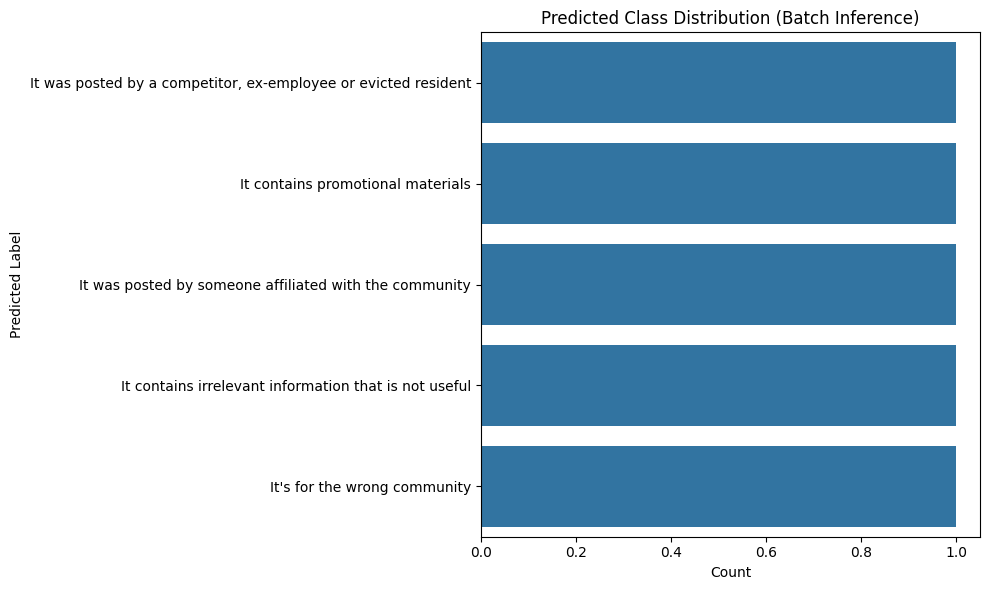

,pred_label,n,avg_margin
0,It contains irrelevant information that is not...,1,0.026380
1,It contains promotional materials,1,0.234344
2,"It was posted by a competitor, ex-employee or ...",1,0.020200
3,It was posted by someone affiliated with the c...,1,0.055304
4,It's for the wrong community,1,0.158937


In [41]:
# --- Generate a lightweight stakeholder report (PNG + CSV) ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("outputs/predictions_with_topk.csv")

# class distribution
plt.figure(figsize=(10,6))
sns.countplot(data=df, y="pred_label", order=df["pred_label"].value_counts().index)
plt.title("Predicted Class Distribution (Batch Inference)")
plt.xlabel("Count"); plt.ylabel("Predicted Label")
plt.tight_layout()
plt.savefig("outputs/report_class_distribution.png", dpi=150)
plt.show()

# export a slim CSV summary
summary = df.groupby("pred_label").agg(
    n=("pred_label","size"),
    avg_margin=("margin_top2","mean")
).reset_index().sort_values("n", ascending=False)
summary.to_csv("outputs/report_summary.csv", index=False)
summary.head(10)


In [42]:
# --- Use calibrated model to export probability Top-K (English comments) ---

import os
import numpy as np
import pandas as pd
import joblib

CALIB_MODEL = "artifacts/model_char_svm_calibrated.pkl"  # from previous step
RAW_INPUT   = "outputs/predictions_with_topk.csv"        # or your original input CSV
OUT_PATH    = "outputs/predictions_with_proba_topk.csv"

# 1) Load calibrated pipeline
cal_mdl = joblib.load(CALIB_MODEL)
labels = cal_mdl.named_steps["clf"].classes_

# 2) Prepare input texts
if os.path.exists(RAW_INPUT):
    df_in = pd.read_csv(RAW_INPUT)
    # If the file already contains prediction columns, fall back to 'text' only
    if "text" not in df_in.columns:
        raise ValueError("Input must contain a 'text' column.")
    X = df_in["text"].astype(str)
else:
    raise FileNotFoundError(f"Not found: {RAW_INPUT}")

# 3) Build a DataFrame with all required numeric features (the pipeline expects them)
dfX = pd.DataFrame({"text": X})
dfX["text_len"]    = dfX["text"].str.len()
dfX["upper_words"] = dfX["text"].str.findall(r"[A-Za-z]{2,}").apply(lambda ws: sum(w.isupper() for w in ws))
dfX["exclamation"] = dfX["text"].str.count("!")
dfX["punctuation"] = dfX["text"].str.count(r"[^\w\s]")

# 4) Predict proba and top-k
proba = cal_mdl.predict_proba(dfX)                        # shape: [n, C]
topk = 3
top_idx = np.argsort(proba, axis=1)[:, -topk:][:, ::-1]   # top-k indices
top_lab = labels[top_idx]
top_p   = np.take_along_axis(proba, top_idx, axis=1)

# 5) Assemble output
out = pd.DataFrame({
    "text": dfX["text"].values,
    "pred_label": top_lab[:, 0],
    "pred_prob":  np.round(top_p[:, 0], 4),
    "top2_label": top_lab[:, 1],
    "top2_prob":  np.round(top_p[:, 1], 4),
    "top3_label": top_lab[:, 2],
    "top3_prob":  np.round(top_p[:, 2], 4),
})
os.makedirs("outputs", exist_ok=True)
out.to_csv(OUT_PATH, index=False)
print(f"Saved probability Top-K to: {OUT_PATH}")

# 6) Queue low-confidence rows (prob < 0.55 as an example)
THRESH = 0.55
queue = out[out["pred_prob"] < THRESH].copy()
queue_path = "outputs/review_queue_prob_lt_055.csv"
queue.to_csv(queue_path, index=False)
print(f"Saved low-confidence queue to: {queue_path}  (#rows={len(queue)})")


Saved probability Top-K to: outputs/predictions_with_proba_topk.csv
Saved low-confidence queue to: outputs/review_queue_prob_lt_055.csv  (#rows=5)


Brier score (lower is better): 0.2279
ECE (lower is better): 0.0879


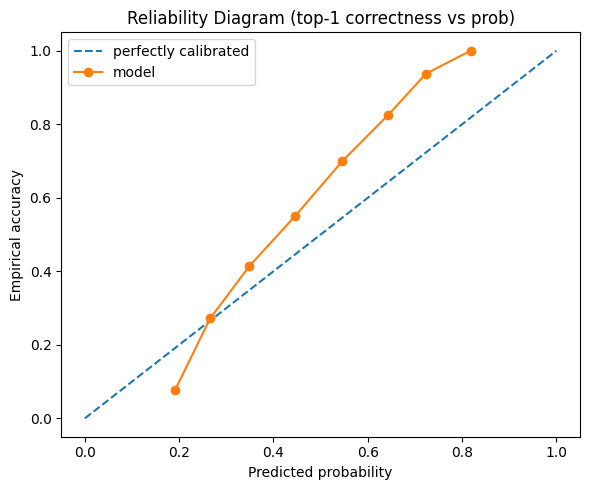

In [43]:
# --- Reliability diagram + ECE (English comments) ---

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve

# NOTE:
# This requires a labeled holdout (X_test, y_test).
# If you do not have X_test/y_test in this notebook session, re-create the split like before.
# Then run predict_proba on X_test and compute per-class reliability or one-vs-rest.

# Example: treat "predicted class" as positive and its prob as confidence
proba_test = cal_mdl.predict_proba(X_test)        # X_test should include all required columns as in training
y_pred_idx = np.argmax(proba_test, axis=1)
y_pred_prob = proba_test[np.arange(len(proba_test)), y_pred_idx]

# Build a binary correctness vector
correct = (cal_mdl.classes_[y_pred_idx] == y_test.values)

# Calibration curve (probability vs accuracy)
prob_true, prob_pred = calibration_curve(correct.astype(int), y_pred_prob, n_bins=10, strategy="uniform")

# Expected Calibration Error (ECE) simple impl.
bins = np.linspace(0, 1, 11)
bin_ids = np.digitize(y_pred_prob, bins) - 1
ece = 0.0
for b in range(10):
    mask = bin_ids == b
    if mask.sum() == 0:
        continue
    acc = correct[mask].mean()
    conf = y_pred_prob[mask].mean()
    ece += (mask.mean()) * abs(acc - conf)

print("Brier score (lower is better):", round(brier_score_loss(correct.astype(int), y_pred_prob), 4))
print("ECE (lower is better):", round(ece, 4))

# Plot
plt.figure(figsize=(6,5))
plt.plot([0,1], [0,1], "--", label="perfectly calibrated")
plt.plot(prob_pred, prob_true, marker="o", label="model")
plt.xlabel("Predicted probability")
plt.ylabel("Empirical accuracy")
plt.title("Reliability Diagram (top-1 correctness vs prob)")
plt.legend()
plt.tight_layout()
plt.savefig("outputs/reliability_diagram.png", dpi=150)
plt.show()


In [44]:
# --- app.py (English comments) ---
# Run (terminal): uvicorn app:app --host 0.0.0.0 --port 8000 --reload

from fastapi import FastAPI
from pydantic import BaseModel
import joblib
import pandas as pd
import numpy as np
import re, string

app = FastAPI(title="Char-level SVM (calibrated) Inference")

# Rebuild numeric features the same way as training
PUNCT = set(string.punctuation)
def count_upper_words(text: str) -> int:
    return sum(1 for w in re.findall(r"[A-Za-z]{2,}", str(text)) if w.isupper())
def count_exclamation(text: str) -> int:
    return str(text).count("!")
def count_punctuation(text: str) -> int:
    return sum(1 for ch in str(text) if ch in PUNCT)

# Load calibrated model once
mdl = joblib.load("artifacts/model_char_svm_calibrated.pkl")
labels = mdl.named_steps["clf"].classes_.tolist()

class PredictRequest(BaseModel):
    texts: list[str]
    topk: int = 3

@app.post("/predict")
def predict(req: PredictRequest):
    texts = [str(t) for t in req.texts]
    df = pd.DataFrame({"text": texts})
    df["text_len"]    = df["text"].str.len()
    df["upper_words"] = df["text"].apply(count_upper_words)
    df["exclamation"] = df["text"].apply(count_exclamation)
    df["punctuation"] = df["text"].apply(count_punctuation)

    proba = mdl.predict_proba(df)  # calibrated probabilities
    pred_idx = np.argmax(proba, axis=1)
    pred = [labels[i] for i in pred_idx]
    pred_prob = proba[np.arange(len(proba)), pred_idx].round(6).tolist()

    k = max(1, min(req.topk, len(labels)))
    top_idx = np.argsort(proba, axis=1)[:, -k:][:, ::-1]
    top_labels = [[labels[j] for j in row] for row in top_idx]
    top_probs  = np.take_along_axis(proba, top_idx, axis=1).round(6).tolist()

    return {
        "pred_label": pred,
        "pred_prob": pred_prob,
        "topk_labels": top_labels,
        "topk_probs": top_probs,
    }


In [46]:
# --- Notebook version of infer.py ---
import os, re, string
import numpy as np
import pandas as pd
import joblib

input_path = "outputs/predictions_with_topk.csv"     
output_path = "outputs/predictions_with_proba.csv"   
topk = 3

PUNCT = set(string.punctuation)
def count_upper_words(text: str) -> int:
    return sum(1 for w in re.findall(r"[A-Za-z]{2,}", str(text)) if w.isupper())
def count_exclamation(text: str) -> int:
    return str(text).count("!")
def count_punctuation(text: str) -> int:
    return sum(1 for ch in str(text) if ch in PUNCT)

mdl = joblib.load("artifacts/model_char_svm_calibrated.pkl")
labels = mdl.named_steps["clf"].classes_

df = pd.read_csv(input_path)
assert "text" in df.columns, "Input CSV must have a 'text' column."
X = df["text"].astype(str)

Xdf = pd.DataFrame({"text": X})
Xdf["text_len"]    = Xdf["text"].str.len()
Xdf["upper_words"] = Xdf["text"].str.findall(r"[A-Za-z]{2,}").apply(lambda ws: sum(w.isupper() for w in ws))
Xdf["exclamation"] = Xdf["text"].str.count("!")
Xdf["punctuation"] = Xdf["text"].str.count(r"[^\w\s]")

proba = mdl.predict_proba(Xdf)
top_idx = np.argsort(proba, axis=1)[:, -topk:][:, ::-1]
top_lab = labels[top_idx]
top_p   = np.take_along_axis(proba, top_idx, axis=1)

out = pd.DataFrame({"text": X})
out["pred_label"] = top_lab[:, 0]
out["pred_prob"]  = np.round(top_p[:, 0], 6)
for k in range(1, topk):
    out[f"top{k+1}_label"] = top_lab[:, k]
    out[f"top{k+1}_prob"]  = np.round(top_p[:, k], 6)

os.makedirs(os.path.dirname(output_path), exist_ok=True)
out.to_csv(output_path, index=False)
print(f"✅ Saved to: {output_path}")


✅ Saved to: outputs/predictions_with_proba.csv


In [47]:
# --- Simple routing policy (English comments) ---

import numpy as np
import pandas as pd

inp = pd.read_csv("outputs/predictions_with_proba_topk.csv")
THRESH = 0.60             # min prob for auto-approve
MAX_TOP2_GAP = 0.10       # if (p1 - p2) < gap, send to review

# when top-2 columns exist:
p1 = inp["pred_prob"].values
p2 = inp["top2_prob"].values

route = np.where(
    (p1 >= THRESH) & ((p1 - p2) >= MAX_TOP2_GAP),
    "auto", "review"
)
inp["route"] = route
inp.to_csv("outputs/routed_predictions.csv", index=False)
print("Saved routing decisions to outputs/routed_predictions.csv")


Saved routing decisions to outputs/routed_predictions.csv


In [49]:
# --- Inspect routed output safely and preview samples per route ---
import pandas as pd
import numpy as np

from pathlib import Path

ROUTED_CSV = Path("outputs/routed_predictions.csv")
assert ROUTED_CSV.exists(), f"File not found: {ROUTED_CSV}"

df = pd.read_csv(ROUTED_CSV)

print("Columns in routed_predictions.csv:", list(df.columns))
print("\nRoute counts:")
print(df["route"].value_counts(dropna=False))

# If margin_top2 is missing, try to recompute it (optional)
if "margin_top2" not in df.columns:
    print("\n'margin_top2' not found. Trying to recompute from the saved model...")
    try:
        import joblib
        mdl = joblib.load("artifacts/model_char_svm.pkl")  # use calibrated model if you prefer
        # The pipeline expects a dataframe with the 'text' column. Build minimal input:
        X_text = pd.DataFrame({"text": df["text"].astype(str)})
        scores = mdl.decision_function(X_text)  # shape: [n_samples, n_classes]
        top2 = np.argsort(scores, axis=1)[:, -2:]
        # margin = top1_score - top2_score  (larger = more confident)
        top1 = scores[np.arange(len(scores)), top2[:, 1]]
        top2s = scores[np.arange(len(scores)), top2[:, 0]]
        margin = top1 - top2s
        df["margin_top2"] = margin
        # persist the recomputed margin so future steps see it
        df.to_csv(ROUTED_CSV, index=False)
        print("Recomputed 'margin_top2' and updated routed_predictions.csv")
    except Exception as e:
        print("Could not recompute 'margin_top2':", repr(e))

# Build the preview columns dynamically (use what exists)
preview_cols = ["text", "pred_label"]
if "pred_prob" in df.columns: preview_cols.append("pred_prob")
if "margin_top2" in df.columns: preview_cols.append("margin_top2")

print("\n--- Per-route preview (top 3 rows) ---")
for r in df["route"].unique():
    subset = df.loc[df["route"] == r, preview_cols]
    print(f"\n=== Route: {r} ===")
    print(subset.head(3))


Columns in routed_predictions.csv: ['text', 'pred_label', 'pred_prob', 'top2_label', 'top2_prob', 'top3_label', 'top3_prob', 'route']

Route counts:
route
review    5
Name: count, dtype: int64

'margin_top2' not found. Trying to recompute from the saved model...
Recomputed 'margin_top2' and updated routed_predictions.csv

--- Per-route preview (top 3 rows) ---

=== Route: review ===
                                                text  \
0  This review contains threatening language and ...   
1  Marketing-only content about discounts and pro...   
2  Posted by someone affiliated with the communit...   

                                          pred_label  pred_prob  margin_top2  
0  It was posted by a competitor, ex-employee or ...     0.3343     0.020200  
1                      It contains false information     0.3520     0.234344  
2                      It contains false information     0.2661     0.055304  


In [51]:
# === Final reporting cell: summarize predictions, (optionally) evaluate, and save artifacts ===
# Notes:
# - Works with outputs/routed_predictions.csv created earlier.
# - If a ground-truth column exists (e.g., 'true_label' or 'y_true'), it will also compute a classification report and confusion matrix.
# - If 'margin_top2' is missing (older runs), it will gracefully fill with NaN and continue.

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Optional: only import sklearn metrics if we actually have ground truth
have_truth = False
truth_col_candidates = ["true_label", "y_true", "label"]
try:
    from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
except Exception:
    pass

# ---------- 0) Config ----------
INPUT_PRED_PATH = "outputs/routed_predictions.csv"               # produced earlier
SUMMARY_DIR     = "outputs"                                      # where reports go
TIMESTAMP       = datetime.now().strftime("%Y%m%d_%H%M%S")
LOWCONF_THRESH  = 0.10                                           # used for counts only

os.makedirs(SUMMARY_DIR, exist_ok=True)

# ---------- 1) Load predictions ----------
df = pd.read_csv(INPUT_PRED_PATH)
print(f"Loaded {len(df)} rows from: {INPUT_PRED_PATH}")

# Expected columns (some may be missing depending on earlier steps)
#   'text' (string), 'pred_label' (string)
#   optional: 'pred_prob' (float, from calibrated model), 'margin_top2' (float), 'route' (string)
for col in ["text", "pred_label"]:
    if col not in df.columns:
        raise ValueError(f"Required column '{col}' not found in {INPUT_PRED_PATH}")

if "margin_top2" not in df.columns:
    df["margin_top2"] = np.nan  # keep pipeline tolerant for older files

# If pred_prob missing, create a proxy column (so later code does not fail)
if "pred_prob" not in df.columns:
    df["pred_prob"] = np.nan

# Identify ground-truth column if present
truth_col = None
for cand in truth_col_candidates:
    if cand in df.columns:
        truth_col = cand
        have_truth = True
        break

# ---------- 2) Basic summaries ----------
# Per-label prediction counts
pred_counts = df["pred_label"].value_counts(dropna=False).rename_axis("pred_label").reset_index(name="count")

# Route distribution (if available)
route_counts = None
if "route" in df.columns:
    route_counts = df["route"].value_counts(dropna=False).rename_axis("route").reset_index(name="count")

# Low-confidence counts (if we have either pred_prob or margin_top2)
lowconf_mask = None
if df["pred_prob"].notna().any():
    lowconf_mask = df["pred_prob"] < LOWCONF_THRESH
elif df["margin_top2"].notna().any():
    # If using margins, "small margin" means less separation between best and 2nd best ⇒ lower confidence
    lowconf_mask = df["margin_top2"] < LOWCONF_THRESH

lowconf_count = int(lowconf_mask.sum()) if lowconf_mask is not None else 0
print(f"Low-confidence rows: {lowconf_count} (threshold={LOWCONF_THRESH})")

# ---------- 3) Save CSV summaries ----------
pred_counts_path  = os.path.join(SUMMARY_DIR, f"pred_counts_by_label_{TIMESTAMP}.csv")
pred_counts.to_csv(pred_counts_path, index=False)

if route_counts is not None:
    route_counts_path = os.path.join(SUMMARY_DIR, f"route_breakdown_{TIMESTAMP}.csv")
    route_counts.to_csv(route_counts_path, index=False)

summary_rows = {
    "n_rows": [len(df)],
    "n_unique_pred_labels": [df["pred_label"].nunique()],
    "lowconf_threshold": [LOWCONF_THRESH],
    "lowconf_count": [lowconf_count],
}
summary_df = pd.DataFrame(summary_rows)
summary_path = os.path.join(SUMMARY_DIR, f"summary_metrics_{TIMESTAMP}.csv")
summary_df.to_csv(summary_path, index=False)

print(f"Saved: {pred_counts_path}")
if route_counts is not None:
    print(f"Saved: {route_counts_path}")
print(f"Saved: {summary_path}")

# ---------- 4) Optional evaluation if ground truth is present ----------
if have_truth:
    y_true = df[truth_col].astype(str)
    y_pred = df["pred_label"].astype(str)

    # Classification report (text) -> save to TXT
    report = classification_report(y_true, y_pred, zero_division=0)
    report_path = os.path.join(SUMMARY_DIR, f"classification_report_{TIMESTAMP}.txt")
    with open(report_path, "w", encoding="utf-8") as f:
        f.write(report)
    print(f"Saved: {report_path}")

    # Confusion matrix (PNG)
    labels_sorted = sorted(sorted(set(y_true)) | sorted(set(y_pred)))
    cm = confusion_matrix(y_true, y_pred, labels=labels_sorted)

    fig, ax = plt.subplots(figsize=(12, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_sorted)
    disp.plot(include_values=True, xticks_rotation=90, cmap="Blues", ax=ax, values_format="d")
    ax.set_title("Confusion Matrix")
    plt.tight_layout()
    cm_path = os.path.join(SUMMARY_DIR, f"confusion_matrix_{TIMESTAMP}.png")
    plt.savefig(cm_path, dpi=180)
    plt.show()
    print(f"Saved: {cm_path}")

else:
    print("Inference-only mode: no ground-truth column found (looked for 'true_label' / 'y_true' / 'label').")

# ---------- 5) Compact preview ----------
print("\nPreview:")
cols_to_show = [c for c in ["text", "pred_label", "pred_prob", "margin_top2", "route"] if c in df.columns]
display(df[cols_to_show].head(10))


Loaded 5 rows from: outputs/routed_predictions.csv
Low-confidence rows: 0 (threshold=0.1)
Saved: outputs/pred_counts_by_label_20251015_001355.csv
Saved: outputs/route_breakdown_20251015_001355.csv
Saved: outputs/summary_metrics_20251015_001355.csv
Inference-only mode: no ground-truth column found (looked for 'true_label' / 'y_true' / 'label').

Preview:


,text,pred_label,pred_prob,margin_top2,route
0,This review contains threatening language and ...,"It was posted by a competitor, ex-employee or ...",0.3343,0.020200,review
1,Marketing-only content about discounts and pro...,It contains false information,0.3520,0.234344,review
2,Posted by someone affiliated with the communit...,It contains false information,0.2661,0.055304,review
3,"Completely unrelated to the property, off-topi...",It contains false information,0.2902,0.026380,review
4,Likely a competitor mentioning prices and othe...,It was posted by someone affiliated with the c...,0.2262,0.158937,review


In [60]:
%pip install --upgrade pip
%pip install pandas scikit-learn matplotlib jupyter sentence-transformers faiss-cpu chromadb
%pip install "fastapi" "uvicorn[standard]" "pydantic" "streamlit" "requests"


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import fastapi, uvicorn, pydantic, streamlit, requests, chromadb, faiss, torch, transformers
print("OK: imports fine")


/Users/tiffanytseng/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


OK: imports fine


In [2]:
%%writefile demo_app.py
import json
import requests
import streamlit as st

API_URL = st.secrets.get("API_URL", "http://127.0.0.1:8000")

st.set_page_config(page_title="AI Review Moderation Demo", layout="wide")
st.title("🛡️ AI Review Moderation Demo")

with st.sidebar:
    st.header("Settings")
    api = st.text_input("API URL", value=API_URL, help="FastAPI endpoint, e.g. http://127.0.0.1:8000")
    top_k = st.slider("Similar examples (Top-K)", 1, 20, 5)

tabs = st.tabs(["Analysis", "Health Check"])

with tabs[0]:
    text = st.text_area("Enter review text", height=180, placeholder="Paste review text here…")
    col1, col2 = st.columns([1,1])
    with col1:
        run = st.button("Analyze")
    with col2:
        clear = st.button("Clear")
    if clear:
        st.experimental_rerun()

    if run and text.strip():
        with st.spinner("Running inference..."):
            try:
                r = requests.post(f"{api}/predict", json={"text": text, "top_k": top_k}, timeout=60)
                r.raise_for_status()
                data = r.json()
            except Exception as e:
                st.error(f"API call failed: {e}")
                st.stop()

        left, right = st.columns([1,1])
        with left:
            st.subheader("Model Output")
            st.write(f"**Model**: `{data.get('model')}`")
            if data.get("reason"):
                st.success(f"**Predicted Reason**: {data['reason']}")
            if data.get("proba") is not None:
                st.write(f"Confidence: {data['proba']:.3f}")
            if data.get("note"):
                st.info(data["note"])

        with right:
            st.subheader("Similar Examples")
            sims = data.get("similar") or []
            if not sims:
                st.write("(No similar examples or missing index)")
            else:
                for i, item in enumerate(sims, 1):
                    meta = item.get("meta", {})
                    text_snippet = item.get("text")
                    score = item.get("score")
                    with st.expander(f"#{i}  distance/score={score}"):
                        if text_snippet:
                            st.write(text_snippet)
                        st.json(meta)

with tabs[1]:
    if st.button("Check API Health"):
        try:
            r = requests.get(f"{api}/health", timeout=10)
            st.json(r.json())
        except Exception as e:
            st.error(f"API unreachable: {e}")


Writing demo_app.py


In [7]:
api_proc.terminate()


In [8]:
import subprocess, sys, shlex, time
cmd = f'"{sys.executable}" -m uvicorn app.main:app --reload --port 8001'
api_proc = subprocess.Popen(shlex.split(cmd))
time.sleep(3)
print("✅ API running at http://127.0.0.1:8001")


INFO:     Will watch for changes in these directories: ['/Users/tiffanytseng/Documents/ai-review-moderation/notebooks']
INFO:     Uvicorn running on http://127.0.0.1:8001 (Press CTRL+C to quit)
INFO:     Started reloader process [96921] using WatchFiles
Process SpawnProcess-1:
Traceback (most recent call last):
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/tiffanytseng/Library/Python/3.9/lib/python/site-packages/uvicorn/_subprocess.py", line 80, in subprocess_started
    target(sockets=sockets)
  File "/Users/tiffanytseng/Library/Python/3.9/lib/python/site-packages/uvicorn/server.py", line 67, in run
    return asyncio_run(self.serve(sockets=socke

✅ API running at http://127.0.0.1:8001


In [9]:
import os, sys, pathlib, textwrap, subprocess, shlex, time

print("cwd =", os.getcwd())
print("in sys.path =", os.getcwd() in sys.path)
print("\nList here:")
print(subprocess.run(shlex.split("ls -la"), capture_output=True, text=True).stdout)

print("\nList app/:")
print(subprocess.run(shlex.split("ls -la app"), capture_output=True, text=True).stdout)
print("\nList app/utils/:")
print(subprocess.run(shlex.split("ls -la app/utils"), capture_output=True, text=True).stdout)


cwd = /Users/tiffanytseng/Documents/ai-review-moderation/notebooks
in sys.path = False

List here:
total 3488
drwxr-xr-x@ 13 tiffanytseng  staff     416 Oct 15 00:41 .
drwxr-xr-x@ 14 tiffanytseng  staff     448 Oct 14 11:34 ..
-rw-r--r--@  1 tiffanytseng  staff    6148 Oct 14 22:31 .DS_Store
drwxr-xr-x@  7 tiffanytseng  staff     224 Oct 14 17:27 .ipynb_checkpoints
-rw-r--r--@  1 tiffanytseng  staff  246866 Oct 14 09:07 01_data_understanding.ipynb
-rw-r--r--@  1 tiffanytseng  staff  153124 Oct 14 09:17 02_modeling_baseline.ipynb
-rw-r--r--@  1 tiffanytseng  staff  251067 Oct 14 14:50 03_feature_expansion.ipynb
-rw-r--r--@  1 tiffanytseng  staff  811004 Oct 14 22:52 04_model_interpretation.ipynb
-rw-r--r--@  1 tiffanytseng  staff  300277 Oct 15 00:41 05_inference_serving.ipynb
drwxr-xr-x@  5 tiffanytseng  staff     160 Oct 14 23:00 artifacts
-rw-r--r--@  1 tiffanytseng  staff    2450 Oct 15 00:36 demo_app.py
drwxr-xr-x@ 20 tiffanytseng  staff     640 Oct 15 00:13 outputs
drwxr-xr-x@  4 

In [10]:
import os
from pathlib import Path

# create folders
for d in ["app", "app/utils", "vector_index", "data/raw", "data/processed", "reports"]:
    Path(d).mkdir(parents=True, exist_ok=True)

# make them Python packages
Path("app/__init__.py").write_text("", encoding="utf-8")
Path("app/utils/__init__.py").write_text("", encoding="utf-8")

print("✅ folders & __init__.py ready")


✅ folders & __init__.py ready


ERROR:    Error loading ASGI app. Could not import module "app.main".
ERROR:    Error loading ASGI app. Could not import module "app.main".


In [11]:
# Stop any previous uvicorn process started from this notebook
try:
    api_proc.terminate()
except Exception:
    pass
print("terminated (if it was running)")


terminated (if it was running)


INFO:     Stopping reloader process [96921]


In [12]:
import os, sys, subprocess, shlex, time

# Ensure current working directory is the one that contains the "app/" folder
print("CWD:", os.getcwd())
assert os.path.isdir("app"), "No 'app' folder in current working directory."

# Make sure Python can import from the current directory
env = os.environ.copy()
env["PYTHONPATH"] = os.getcwd() + (":" + env["PYTHONPATH"] if "PYTHONPATH" in env else "")

# Start uvicorn WITHOUT --reload (reloader often drops sys.path when spawned from notebooks)
cmd = f'"{sys.executable}" -m uvicorn app.main:app --host 127.0.0.1 --port 8001 --app-dir .'
print("Launching:", cmd)
api_proc = subprocess.Popen(shlex.split(cmd), stdout=subprocess.PIPE, stderr=subprocess.STDOUT, env=env)

# Wait a bit, then print a few log lines
time.sleep(2)
for _ in range(20):
    line = api_proc.stdout.readline().decode("utf-8", errors="ignore").strip()
    if not line:
        break
    print(line)

print("Try: http://127.0.0.1:8001/health")


CWD: /Users/tiffanytseng/Documents/ai-review-moderation/notebooks
Launching: "/Library/Developer/CommandLineTools/usr/bin/python3" -m uvicorn app.main:app --host 127.0.0.1 --port 8001 --app-dir .
ERROR:    Error loading ASGI app. Could not import module "app.main".
Try: http://127.0.0.1:8001/health


In [13]:
import sys, os, importlib, traceback

# ensure current dir is on sys.path
if os.getcwd() not in sys.path:
    sys.path.insert(0, os.getcwd())

try:
    mod = importlib.import_module("app.main")
    print("Imported app.main OK. app =", getattr(mod, "app", None))
except Exception:
    traceback.print_exc()


Traceback (most recent call last):
  File "/var/folders/gz/bhmz7vj94s7207h9k2_rgndc0000gn/T/ipykernel_96767/6253699.py", line 8, in <module>
    mod = importlib.import_module("app.main")
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/importlib/__init__.py", line 127, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1030, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1007, in _find_and_load
  File "<frozen importlib._bootstrap>", line 984, in _find_and_load_unlocked
ModuleNotFoundError: No module named 'app.main'


In [14]:
import os
from pathlib import Path

# 1) ensure folders
for d in ["app", "app/utils", "vector_index", "data/raw", "data/processed", "reports"]:
    Path(d).mkdir(parents=True, exist_ok=True)

# 2) make them Python packages
Path("app/__init__.py").write_text("", encoding="utf-8")
Path("app/utils/__init__.py").write_text("", encoding="utf-8")

# 3) write config.py
Path("app/config.py").write_text("""from pathlib import Path
MODEL_FINAL = Path("model_final.pkl")
MODEL_BASELINE = Path("model_baseline.pkl")
FAISS_INDEX = Path("vector_index/index.faiss")
FAISS_IDMAP = Path("vector_index/id_map.json")
CHROMA_DIR = Path("vector_index/chroma_db")
EMBED_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
TOP_K = 5
""", encoding="utf-8")

# 4) write loaders.py
Path("app/utils/loaders.py").write_text(r'''import json
from pathlib import Path
from typing import Optional, Tuple, List

import joblib
import numpy as np
from sentence_transformers import SentenceTransformer

try:
    import faiss
except Exception:
    faiss = None

try:
    import chromadb
except Exception:
    chromadb = None

from app import config


class LazyEmbedder:
    """Lazy singleton for SentenceTransformer."""
    _model: Optional[SentenceTransformer] = None

    @classmethod
    def get(cls) -> SentenceTransformer:
        if cls._model is None:
            cls._model = SentenceTransformer(config.EMBED_MODEL_NAME)
        return cls._model


def load_model() -> Tuple[Optional[object], str]:
    """Load final model first, then fallback to baseline."""
    if config.MODEL_FINAL.exists():
        try:
            return joblib.load(config.MODEL_FINAL), "final"
        except Exception as e:
            return None, f"Failed to load model_final.pkl: {e}"

    if config.MODEL_BASELINE.exists():
        try:
            return joblib.load(config.MODEL_BASELINE), "baseline"
        except Exception as e:
            return None, f"Failed to load model_baseline.pkl: {e}"

    return None, "No available model found."


class FaissIndex:
    """FAISS index wrapper."""
    def __init__(self, index_path: Path, idmap_path: Path):
        self.index = None
        self.idmap = []
        self.dim = None
        self.index_path = index_path
        self.idmap_path = idmap_path

    def exists(self) -> bool:
        return self.index_path.exists() and self.idmap_path.exists() and faiss is not None

    def load(self):
        if faiss is None:
            raise RuntimeError("faiss-cpu not installed.")
        self.index = faiss.read_index(str(self.index_path))
        self.dim = self.index.d
        with open(self.idmap_path, "r", encoding="utf-8") as f:
            self.idmap = json.load(f)

    def search(self, query_vec: np.ndarray, top_k: int) -> List[dict]:
        if self.index is None:
            return []
        D, I = self.index.search(query_vec.astype("float32"), top_k)
        results = []
        for dist, idx in zip(D[0], I[0]):
            if idx == -1:
                continue
            meta = self.idmap[idx] if 0 <= idx < len(self.idmap) else {}
            results.append({"score": float(dist), "meta": meta})
        return results


class ChromaIndex:
    """Chroma vector store wrapper."""
    def __init__(self, persist_dir: Path, collection_name: str = "reviews"):
        self.client = None
        self.collection = None
        self.persist_dir = persist_dir
        self.collection_name = collection_name

    def exists(self) -> bool:
        return chromadb is not None and self.persist_dir.exists()

    def load(self):
        if chromadb is None:
            raise RuntimeError("chromadb not installed.")
        self.client = chromadb.PersistentClient(path=str(self.persist_dir))
        self.collection = self.client.get_or_create_collection(self.collection_name)

    def search(self, query_texts: List[str], top_k: int) -> List[dict]:
        if self.collection is None:
            return []
        res = self.collection.query(query_texts=query_texts, n_results=top_k)
        out = []
        for i in range(len(res["ids"][0])):
            out.append({
                "score": float(res["distances"][0][i]) if "distances" in res else None,
                "meta": res["metadatas"][0][i] if "metadatas" in res else {},
                "text": res["documents"][0][i] if "documents" in res else None,
            })
        return out


def get_vector_backends():
    """Auto-detect FAISS or Chroma."""
    faiss_idx = FaissIndex(config.FAISS_INDEX, config.FAISS_IDMAP)
    chroma_idx = ChromaIndex(config.CHROMA_DIR)

    if faiss_idx.exists():
        faiss_idx.load()
        def _search_vec(emb, k):
            return faiss_idx.search(emb, k)
        return _search_vec, None, "faiss"

    if chroma_idx.exists():
        chroma_idx.load()
        def _search_txt(text, k):
            return chroma_idx.search([text], k)
        return None, _search_txt, "chroma"

    return None, None, "none"
''', encoding="utf-8")

# 5) write main.py
Path("app/main.py").write_text(r'''from typing import Optional, List
from pydantic import BaseModel
from fastapi import FastAPI
from fastapi.middleware.cors import CORSMiddleware
import numpy as np

from app.utils.loaders import LazyEmbedder, load_model, get_vector_backends
from app import config

app = FastAPI(title="AI Review Moderation API", version="0.1.0")

app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],
    allow_headers=["*"],
    allow_methods=["*"],
)

MODEL, MODEL_TAG = load_model()
EMBEDDER = LazyEmbedder.get()
search_with_vector, search_with_text, BACKEND = get_vector_backends()

class PredictIn(BaseModel):
    text: str
    top_k: Optional[int] = config.TOP_K

class PredictOut(BaseModel):
    reason: Optional[str] = None
    proba: Optional[float] = None
    model: str
    similar: Optional[List[dict]] = None
    note: Optional[str] = None

@app.get("/health")
def health():
    return {
        "status": "ok",
        "model": MODEL_TAG if MODEL is not None else "none",
        "vector_backend": BACKEND
    }

@app.post("/predict", response_model=PredictOut)
def predict(payload: PredictIn):
    notes = []

    emb = EMBEDDER.encode([payload.text])
    emb_np = np.array(emb, dtype="float32")

    reason = None
    proba = None
    model_name = "none"
    if MODEL is None:
        notes.append("No model found. Similarity search only.")
    else:
        model_name = MODEL_TAG
        try:
            if hasattr(MODEL, "predict_proba"):
                proba = float(np.max(MODEL.predict_proba(emb_np)[0]))
            reason = str(MODEL.predict(emb_np)[0])
        except Exception as e:
            notes.append(f"Classification error: {e}")

    similar = None
    try:
        k = payload.top_k or config.TOP_K
        if search_with_vector is not None:
            similar = search_with_vector(emb_np, k)
        elif search_with_text is not None:
            similar = search_with_text(payload.text, k)
        else:
            notes.append("No vector index available.")
    except Exception as e:
        notes.append(f"Similarity search error: {e}")

    return PredictOut(
        reason=reason,
        proba=proba,
        model=model_name,
        similar=similar,
        note=" | ".join(notes) if notes else None
    )
''', encoding="utf-8")

# show tree
import subprocess, shlex
print("\nTree:")
print(subprocess.run(shlex.split("ls -la app"), capture_output=True, text=True).stdout)
print(subprocess.run(shlex.split("ls -la app/utils"), capture_output=True, text=True).stdout)



Tree:
total 16
-rw-r--r--@  1 tiffanytseng  staff     0 Oct 15 00:46 __init__.py
drwxr-xr-x@  6 tiffanytseng  staff   192 Oct 15 00:46 .
drwxr-xr-x@ 16 tiffanytseng  staff   512 Oct 15 00:45 ..
-rw-r--r--@  1 tiffanytseng  staff   315 Oct 15 00:46 config.py
-rw-r--r--@  1 tiffanytseng  staff  2250 Oct 15 00:46 main.py
drwxr-xr-x@  4 tiffanytseng  staff   128 Oct 15 00:46 utils

total 16
-rw-r--r--@ 1 tiffanytseng  staff     0 Oct 15 00:46 __init__.py
drwxr-xr-x@ 4 tiffanytseng  staff   128 Oct 15 00:46 .
drwxr-xr-x@ 6 tiffanytseng  staff   192 Oct 15 00:46 ..
-rw-r--r--@ 1 tiffanytseng  staff  4137 Oct 15 00:46 loaders.py



/Users/tiffanytseng/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Process SpawnProcess-3:
Traceback (most recent call last):
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/tiffanytseng/Library/Python/3.9/lib/python/site-packages/uvicorn/_subprocess.py", line 80, in subprocess_started
    target(sockets=sockets)
  File "/Users/tiffanytseng/Library/Python/3.9/lib/python/site-packages/uvicorn/server.py", line 67, in run
    return asyncio_run

In [18]:
# Handle rare classes before stratified split; fallback to non-stratified if still impossible
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# --- Config ---
MIN_PER_CLASS = 2   # minimum occurrences required to allow stratification
USE_OTHER_BUCKET = True  # merge rare classes into 'OTHER' to keep them, else drop them

# 1) Basic cleaning (idempotent)
df["review_text"] = df["review_text"].astype(str)
df = df[df["review_text"].str.len() >= 3].copy()
df = df.dropna(subset=["reason"]).copy()

# 2) Inspect class counts
counts = df["reason"].value_counts().sort_values()
print("Class counts before handling:\n", counts)

# 3) Merge or drop rare classes
rare = counts[counts < MIN_PER_CLASS].index.tolist()
if len(rare) > 0:
    if USE_OTHER_BUCKET:
        df["reason"] = df["reason"].where(~df["reason"].isin(rare), other="OTHER")
        print(f"Merged {len(rare)} rare classes into 'OTHER'.")
    else:
        before = len(df)
        df = df[~df["reason"].isin(rare)].copy()
        print(f"Dropped {before - len(df)} samples from {len(rare)} rare classes.")

# 4) Re-check counts after handling
counts2 = df["reason"].value_counts().sort_values()
print("Class counts after handling:\n", counts2)

# 5) Try stratified split; if it still fails, fallback to non-stratified
def safe_splits(data: pd.DataFrame, seed: int = 42):
    y = data["reason"]
    try:
        train_df, temp_df = train_test_split(
            data, test_size=0.30, random_state=seed, stratify=y
        )
        val_df, test_df = train_test_split(
            temp_df, test_size=0.50, random_state=seed, stratify=temp_df["reason"]
        )
        mode = "stratified"
    except Exception as e:
        print(f"[Warn] Stratified split failed: {e}\nFalling back to non-stratified split.")
        train_df, temp_df = train_test_split(
            data, test_size=0.30, random_state=seed, shuffle=True
        )
        val_df, test_df = train_test_split(
            temp_df, test_size=0.50, random_state=seed, shuffle=True
        )
        mode = "non-stratified"
    return train_df, val_df, test_df, mode

train_df, val_df, test_df, split_mode = safe_splits(df, seed=42)
print(f"Split mode: {split_mode}")
print("Sizes:", len(train_df), len(val_df), len(test_df))
print("Unique classes (train):", train_df["reason"].nunique())


Class counts before handling:
 reason
20                                                                   1
15                                                                   1
22                                                                   1
13                                                                   2
12                                                                   2
16                                                                   3
It's influenced by COVID-19 / conavirus                            213
It contains promotional materials                                 1135
It contains irrelevant information that is not useful             1798
It's for the wrong community                                      2017
It was posted by someone affiliated with the community            4129
It violates ApartmentRatings' privacy standards                   4381
It contains threats, lewdness or hate speech                      5546
It was posted by a competitor, ex-emplo

In [21]:
# Build a serializable pipeline: TF-IDF (1-2gram) + simple metadata + LogisticRegression (no lambdas)
import re
import numpy as np
import pandas as pd
from scipy import sparse
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Ensure we work with a DataFrame so ColumnTransformer can select by column name
train_X = train_df[["review_text"]].copy()
val_X   = val_df[["review_text"]].copy()
test_X  = test_df[["review_text"]].copy()
train_y = train_df["reason"].copy()
val_y   = val_df["reason"].copy()
test_y  = test_df["reason"].copy()

URL_REGEX = re.compile(r"https?://|www\.", re.IGNORECASE)

class MetaFeats(BaseEstimator, TransformerMixin):
    """Compute simple numeric metadata from raw text."""
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        # X is a 1-D array-like of raw text (ColumnTransformer passes a pandas Series)
        if isinstance(X, (pd.DataFrame, np.ndarray)) and getattr(X, "ndim", 1) > 1:
            # when ColumnTransformer passes a 2D array with shape (N,), flatten to 1D
            X = X.ravel()
        X = pd.Series(X, dtype=str)
        lens = X.str.len().astype(np.float32).to_numpy().reshape(-1, 1)
        has_url = X.str.contains(URL_REGEX).astype(np.float32).to_numpy().reshape(-1, 1)
        return np.hstack([lens, has_url])  # dense 2 columns

# Text vectorizer
text_vect = TfidfVectorizer(ngram_range=(1, 2), min_df=2, max_features=200_000)

# ColumnTransformer: both transformers read from the same "review_text" column
preprocessor = ColumnTransformer(
    transformers=[
        ("tfidf", text_vect, "review_text"),
        ("meta",  MetaFeats(), "review_text"),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
    sparse_threshold=0.3,  # returns sparse if the majority is sparse
)

# Classifier: increase iterations; liblinear is robust for small/medium data (OvR)
clf = LogisticRegression(
    max_iter=1000,
    solver="liblinear",
    class_weight="balanced",
    multi_class="ovr"
)

pipe = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", clf),
])

pipe


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('tfidf',
                                                  TfidfVectorizer(max_features=200000,
                                                                  min_df=2,
                                                                  ngram_range=(1,
                                                                               2)),
                                                  'review_text'),
                                                 ('meta', MetaFeats(),
                                                  'review_text')],
                                   verbose_feature_names_out=False)),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    multi_class='ovr', solver='liblinear'))])

In [24]:
# Train, evaluate (macro-F1 primary), plot confusion matrix, and save model + reports
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import joblib
import json

# Ensure X is a DataFrame with a 'review_text' column (not a Series)
train_X = train_df[['review_text']].copy()
val_X   = val_df[['review_text']].copy()
test_X  = test_df[['review_text']].copy()

train_y = train_df['reason'].copy()
val_y   = val_df['reason'].copy()
test_y  = test_df['reason'].copy()

# Fit with DataFrame X
pipe.fit(train_X, train_y)

# Evaluate on val & test
def eval_split(name, X, y_true):
    y_pred = pipe.predict(X)
    macro = f1_score(y_true, y_pred, average="macro")
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    cm = confusion_matrix(y_true, y_pred, labels=sorted(df["reason"].unique()))
    return {"name": name, "macro_f1": macro, "report": report, "labels": sorted(df["reason"].unique()), "cm": cm.tolist()}

val_metrics = eval_split("val", val_X, val_y)
test_metrics = eval_split("test", test_X, test_y)

# Save model
joblib.dump(pipe, "model_baseline.pkl")

# Save metrics JSON
out = {"val": {"macro_f1": val_metrics["macro_f1"], "report": val_metrics["report"]},
       "test": {"macro_f1": test_metrics["macro_f1"], "report": test_metrics["report"]}}
with open(REPORT_DIR / "baseline_metrics.json", "w", encoding="utf-8") as f:
    json.dump(out, f, ensure_ascii=False, indent=2)

# Plot and save confusion matrix (test)
labels = test_metrics["labels"]
cm = np.array(test_metrics["cm"])

fig = plt.figure(figsize=(max(6, 0.6*len(labels)), max(5, 0.6*len(labels))))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (Test)")
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45, ha="right")
plt.yticks(tick_marks, labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
fig.savefig(REPORT_DIR / "confusion_matrix.png", dpi=160, bbox_inches="tight")
plt.close(fig)

val_metrics["macro_f1"], test_metrics["macro_f1"]


/Users/tiffanytseng/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


(0.19032088575741354, 0.19106403426695923)

In [27]:
# Quick inference sanity check using the saved pipeline (expects a DataFrame)
import joblib
import pandas as pd
import numpy as np

model = joblib.load("model_baseline.pkl")

samples = [
    "This post contains spam links like http://cheap.example",
    "Hate speech targeting a protected group",
    "Repeated ads and promotions"
]

# Wrap as a DataFrame with the exact column name used in training
X = pd.DataFrame({"review_text": samples})

# Predicted labels
preds = model.predict(X)
print("Predicted labels:", preds)

# Optional: predicted probabilities (if classifier supports predict_proba)
if hasattr(model.named_steps["clf"], "predict_proba"):
    proba = model.predict_proba(X)
    classes = model.named_steps["clf"].classes_
    # Show top-1 label and confidence per row
    top_idx = np.argmax(proba, axis=1)
    top_conf = proba[np.arange(len(samples)), top_idx]
    top_label = classes[top_idx]
    for i, (lbl, conf) in enumerate(zip(top_label, top_conf)):
        print(f"[{i}] top-1 = {lbl} | confidence = {conf:.3f}")


Predicted labels: ['It contains irrelevant information that is not useful'
 'It contains irrelevant information that is not useful'
 'It contains irrelevant information that is not useful']
[0] top-1 = It contains irrelevant information that is not useful | confidence = 0.268
[1] top-1 = It contains irrelevant information that is not useful | confidence = 0.268
[2] top-1 = It contains irrelevant information that is not useful | confidence = 0.215


In [6]:
# Robust loader + FAISS index builder (works from notebooks/ or project root)
# - Tries common relative paths for the cleaned CSV
# - Prints the resolved path
# - Builds FAISS index and id_map

import os
import json
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm import tqdm

# --- Resolve cleaned CSV path ---
CANDIDATES = [
    "../data/processed/reported_reviews_clean.csv",      # if running from project root
    "notebooks/data/processed/reported_reviews_clean.csv",
    "../data/processed/reviews_clean.csv",   # if running from notebooks/
]
CLEAN_PATH = None
for p in CANDIDATES:
    if Path(p).exists():
        CLEAN_PATH = Path(p)
        break

if CLEAN_PATH is None:
    raise FileNotFoundError(
        "Could not find 'reviews_clean.csv'. Tried:\n  - " + "\n  - ".join(CANDIDATES) +
        "\n\nTip: if your file is elsewhere, set CLEAN_PATH manually, e.g.:\n"
        "CLEAN_PATH = Path('../outputs/reviews_clean.csv')"
    )

print(f"[OK] Using cleaned CSV: {CLEAN_PATH.resolve()}")

# --- Load dataframe ---
df = pd.read_csv(CLEAN_PATH)
print("Loaded:", df.shape, "rows")

# --- Ensure required column exists ---
assert "review_text" in df.columns, "Missing 'review_text' column in cleaned CSV."

# --- Optional: select metadata columns if present ---
meta_cols = [c for c in ["object_id", "reason", "date_created", "complex_id"] if c in df.columns]

# --- Import embeddings + FAISS ---
try:
    from sentence_transformers import SentenceTransformer
except Exception as e:
    raise RuntimeError("sentence-transformers is required. Install with: pip install sentence-transformers") from e

try:
    import faiss  # type: ignore
except Exception as e:
    raise RuntimeError("faiss-cpu is required. Install with: pip install faiss-cpu") from e

# --- Prepare output dir ---
VEC_DIR = Path("vector_index")
VEC_DIR.mkdir(parents=True, exist_ok=True)
INDEX_PATH = VEC_DIR / "index.faiss"
IDMAP_PATH = VEC_DIR / "id_map.json"

# --- Load embedder ---
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# --- Encode in batches ---
texts = df["review_text"].astype(str).tolist()
batch_size = 256
emb_parts = []
for i in tqdm(range(0, len(texts), batch_size), desc="Encoding"):
    batch = texts[i:i + batch_size]
    vec = model.encode(
        batch,
        batch_size=min(len(batch), 256),
        show_progress_bar=False,
        convert_to_numpy=True,
        normalize_embeddings=False,  # keep raw embeddings (we use L2 index)
    ).astype("float32")
    emb_parts.append(vec)

emb = np.vstack(emb_parts)
dim = emb.shape[1]
print(f"Embeddings shape: {emb.shape}")

# --- Build FAISS L2 index ---
index = faiss.IndexFlatL2(dim)
index.add(emb)
faiss.write_index(index, str(INDEX_PATH))

# --- Save id_map (per-vector metadata) ---
id_map = []
for _, row in df.reset_index(drop=True).iterrows():
    meta = {k: (None if pd.isna(row[k]) else row[k]) for k in meta_cols}
    id_map.append(meta)

with open(IDMAP_PATH, "w", encoding="utf-8") as f:
    json.dump(id_map, f, ensure_ascii=False, indent=2)

print("[DONE] Wrote:")
print(" -", INDEX_PATH.resolve())
print(" -", IDMAP_PATH.resolve())


[OK] Using cleaned CSV: /Users/tiffanytseng/Documents/ai-review-moderation/data/processed/reported_reviews_clean.csv
Loaded: (32206, 10) rows


Encoding: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [01:58<00:00,  1.07it/s]


Embeddings shape: (32206, 384)
[DONE] Wrote:
 - /Users/tiffanytseng/Documents/ai-review-moderation/notebooks/vector_index/index.faiss
 - /Users/tiffanytseng/Documents/ai-review-moderation/notebooks/vector_index/id_map.json


In [3]:
# --- Load dependencies and reconnect saved objects ---
import json
import numpy as np
import pandas as pd
from pathlib import Path
import faiss

# --- Reconnect FAISS index and id_map paths ---
VEC_DIR = Path("vector_index")
INDEX_PATH = VEC_DIR / "index.faiss"
IDMAP_PATH = VEC_DIR / "id_map.json"

# --- Reload FAISS index ---
index = faiss.read_index(str(INDEX_PATH))

# --- Reload the same cleaned dataset you used before ---
df = pd.read_csv("../data/processed/reported_reviews_clean.csv")  # ✅ adjust if needed
print("Loaded df:", df.shape)

# --- Reload id_map for metadata alignment ---
with open(IDMAP_PATH, "r", encoding="utf-8") as f:
    id_map = json.load(f)

# --- Optional sanity check ---
print("id_map length:", len(id_map))

# --- Prepare embeddings for recall test ---
# (We only need embeddings to query; if not saved, re-encode quickly with smaller batch)
from sentence_transformers import SentenceTransformer
texts = df["review_text"].astype(str).tolist()
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
emb = model.encode(texts, batch_size=256, show_progress_bar=True, convert_to_numpy=True).astype("float32")

assert len(id_map) == len(df) == emb.shape[0], "Index / id_map / df length mismatch"

# --- Compute Recall@5 ---
k = 6
D, I = index.search(emb, k)
same_any = []
for row_idx, neighs in enumerate(I):
    neighs_wo_self = [j for j in neighs if j != row_idx][:5]
    target = df.iloc[row_idx]["reason"]
    same = any(df.iloc[n]["reason"] == target for n in neighs_wo_self)
    same_any.append(1.0 if same else 0.0)

recall_at5 = float(np.mean(same_any))
print("Recall@5 =", round(recall_at5, 4))


Loaded df: (32206, 10)
id_map length: 32206


/Users/tiffanytseng/Documents/ai-review-moderation/.venv311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [01:39<00:00,  1.26it/s]


Recall@5 = 0.7555


In [4]:
# Quick local search helper to preview Top-k neighbors from the FAISS index we just built
def faiss_search(query_text: str, top_k: int = 5):
    qv = model.encode([query_text], convert_to_numpy=True).astype("float32")
    D, I = index.search(qv, top_k)
    out = []
    for dist, idx in zip(D[0], I[0]):
        meta = id_map[idx] if 0 <= idx < len(id_map) else {}
        text = df.iloc[idx]["review_text"]
        out.append({"score": float(dist), "meta": meta, "text": text})
    return out

faiss_search("This post contains spam links http://spam.example", top_k=5)


[{'score': 1.2099928855895996,
  'meta': {'object_id': '1483492',
   'reason': 'It was posted by someone affiliated with the community',
   'date_created': '2019-08-15 09:55:14',
   'complex_id': 262789500153204.0},
  'text': 'I ve just moved back into these great lofts since returning to town.  These are beautiful&#44; large lofts with super high-end amenities&#44; wonderful location with nice residents and caring manager/owner.  I ve renewed here previously&#44; and these were my first choice when I returned.  I m thankful they had an opening.\n\nYou just know that a building is well-constructed and maintained when it s owner occupied.  And that certainly shows here.  It s not with the big building issues since this is just the right size.  I do suspect that the spammer will post again&#44; but we recognize that s ALL that is.  As a renewing tenant&#44; I know better!'},
 {'score': 1.3253962993621826,
  'meta': {'object_id': '112165073',
   'reason': 'It contains false information',


In [6]:
import requests, json

API_URL = "http://127.0.0.1:8010"  # 👈 用剛剛新的 port 8010
payload = {"text": "This post contains spam links http://spam.example", "k": 5}

r = requests.post(f"{API_URL}/similar", json=payload, timeout=30)
print(r.status_code)
print(json.dumps(r.json(), indent=2)[:1500])


200
{
  "items": [
    {
      "index": 12559,
      "distance": 1.2099928855895996,
      "meta": {
        "object_id": "1483492",
        "reason": "It was posted by someone affiliated with the community",
        "date_created": "2019-08-15 09:55:14",
        "complex_id": 262789500153204.0
      }
    },
    {
      "index": 24152,
      "distance": 1.3253962993621826,
      "meta": {
        "object_id": "112165073",
        "reason": "It contains false information",
        "date_created": "2018-06-09 13:26:45",
        "complex_id": 712255225751104.0
      }
    }
  ],
  "vector_backend": "faiss"
}


In [7]:
# Basic imports and notebook-wide settings
import os
from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer

# Paths
ROOT = Path.cwd().resolve().parents[0] if (Path.cwd().name == "notebooks") else Path.cwd()
DATA_DIR = ROOT / "data"
PROC_DIR = DATA_DIR / "processed"
REPORT_DIR = ROOT / "reports" / "insights"
REPORT_DIR.mkdir(parents=True, exist_ok=True)

# Matplotlib defaults
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.dpi"] = 120

print("ROOT:", ROOT)
print("Saving figures to:", REPORT_DIR)


ROOT: /Users/tiffanytseng/Documents/ai-review-moderation
Saving figures to: /Users/tiffanytseng/Documents/ai-review-moderation/reports/insights


In [8]:
# Load cleaned dataset produced earlier (adjust filename if different)
csv_candidates = [
    PROC_DIR / "reviews_clean.csv",
    PROC_DIR / "reported_reviews_clean.csv",  # if you used this name earlier
]
csv_path = None
for p in csv_candidates:
    if p.exists():
        csv_path = p
        break

if not csv_path:
    raise FileNotFoundError("Cannot find cleaned CSV in data/processed/. Please check the filename.")

df = pd.read_csv(csv_path)
print("Loaded:", csv_path, "shape:", df.shape)
df.head(3)


Loaded: /Users/tiffanytseng/Documents/ai-review-moderation/data/processed/reported_reviews_clean.csv shape: (32206, 10)


,object_id,complex_id,vote_reason_id,reason,date_created,date_updated,review_text,text_len,day_of_week,hour_of_day
0,112885551,9.723591e+14,6,"It contains threats, lewdness or hate speech",2021-09-27 13:52:34,2021-09-27 13:52:34,Initially I was excited about moving to Settle...,1052.0,Monday,13.0
1,112795026,9.199332e+18,1,It's for the wrong community,2021-08-23 17:11:15,2021-08-23 17:11:15,Love my apartment and the staff here. I like t...,209.0,Monday,17.0
2,112795026,9.199332e+18,1,It's for the wrong community,2021-08-23 16:55:42,2021-08-23 16:55:42,Love my apartment and the staff here. I like t...,209.0,Monday,16.0


In [9]:
# Ensure time columns exist and convert to datetime; create time features
for col in ["date_created", "date_updated"]:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")

if "date_created" not in df.columns:
    raise ValueError("date_created column is required for time trend plots.")

# Derive time features
df["year_month"] = df["date_created"].dt.to_period("M").astype(str)
df["day_of_week"] = df["date_created"].dt.day_name()
df["hour_of_day"] = df["date_created"].dt.hour

# Basic text hygiene
df["review_text"] = df["review_text"].astype(str).fillna("").str.strip()
df = df[df["review_text"].str.len() >= 3].copy()

# Ensure reason exists
if "reason" not in df.columns:
    raise ValueError("reason column is required for class-wise analysis.")


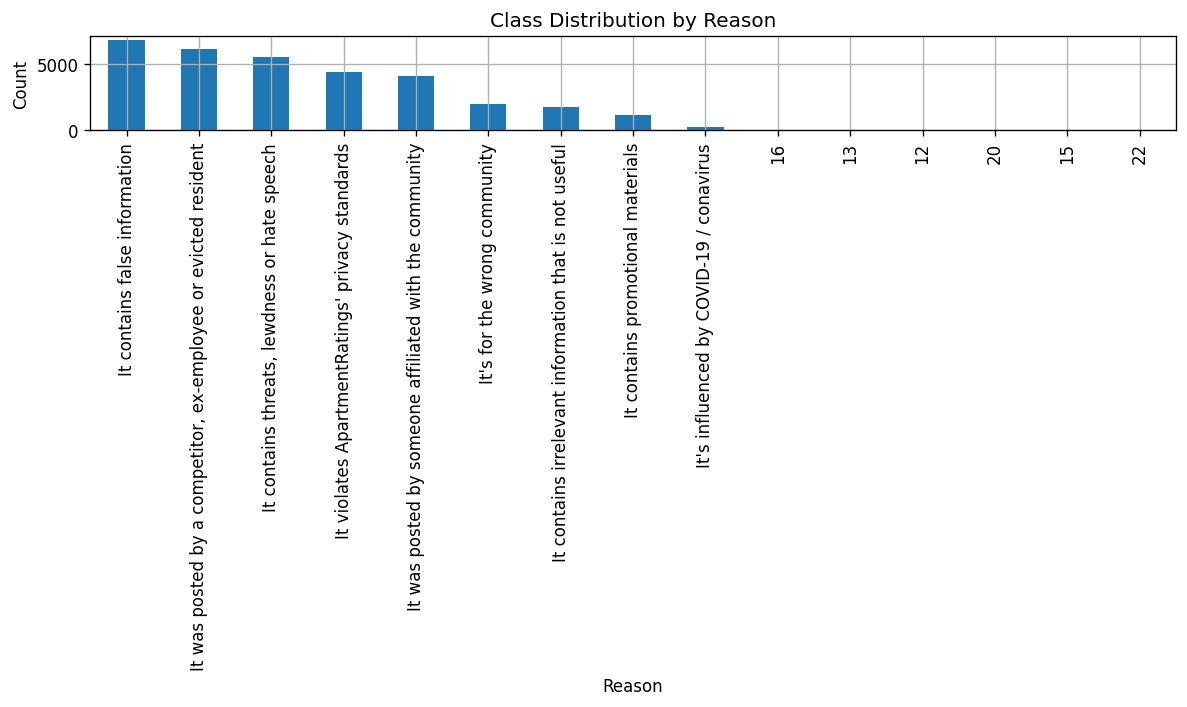

Saved: /Users/tiffanytseng/Documents/ai-review-moderation/reports/insights/class_distribution.png


In [10]:
# Plot class distribution and save
counts = df["reason"].value_counts().sort_values(ascending=False)
ax = counts.plot(kind="bar")
ax.set_title("Class Distribution by Reason")
ax.set_xlabel("Reason")
ax.set_ylabel("Count")
plt.tight_layout()
out_path = REPORT_DIR / "class_distribution.png"
plt.savefig(out_path)
plt.show()
print("Saved:", out_path)

# Also save table
counts.to_csv(REPORT_DIR / "class_distribution.csv", header=["count"])


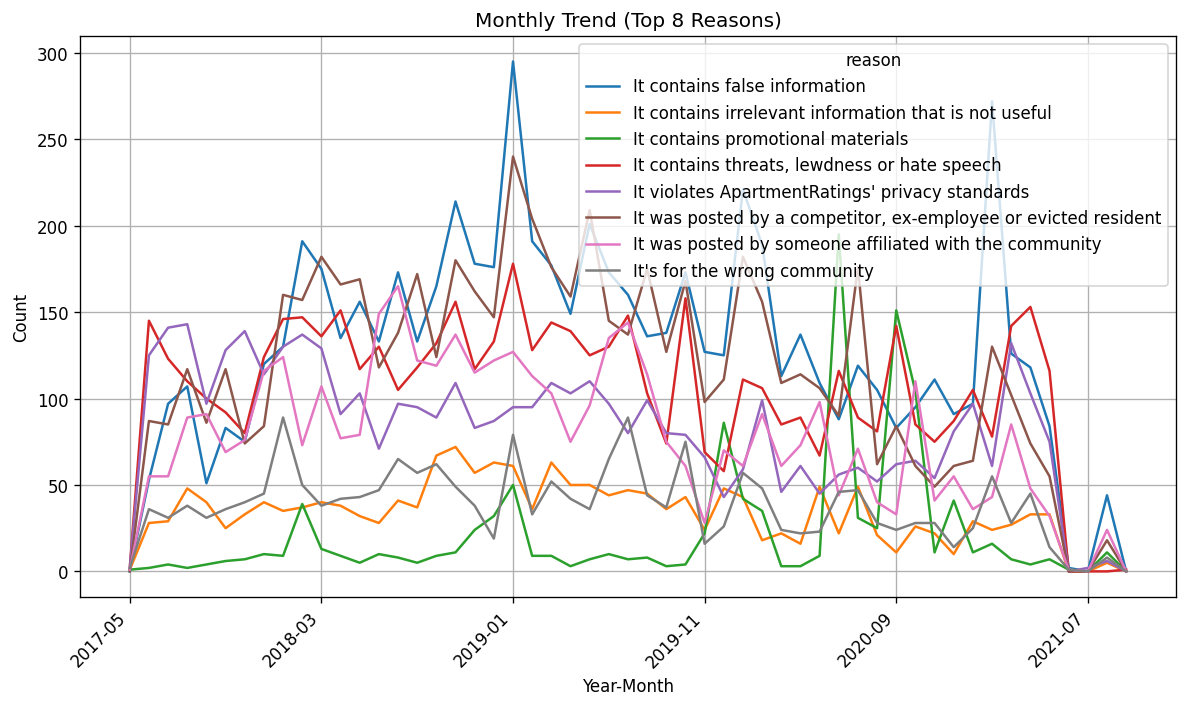

Saved: /Users/tiffanytseng/Documents/ai-review-moderation/reports/insights/monthly_trend_topN.png


In [11]:
# Monthly trend for top-N frequent reasons
TOP_N = 8
top_reasons = counts.head(TOP_N).index.tolist()

trend = (
    df[df["reason"].isin(top_reasons)]
    .groupby(["year_month", "reason"])
    .size()
    .reset_index(name="count")
    .sort_values(["year_month", "reason"])
)

# Pivot for plotting multiple lines
pivot = trend.pivot(index="year_month", columns="reason", values="count").fillna(0)

ax = pivot.plot()
ax.set_title(f"Monthly Trend (Top {TOP_N} Reasons)")
ax.set_xlabel("Year-Month")
ax.set_ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
out_path = REPORT_DIR / "monthly_trend_topN.png"
plt.savefig(out_path)
plt.show()
print("Saved:", out_path)

# Save trend CSV
trend.to_csv(REPORT_DIR / "monthly_trend_topN.csv", index=False)


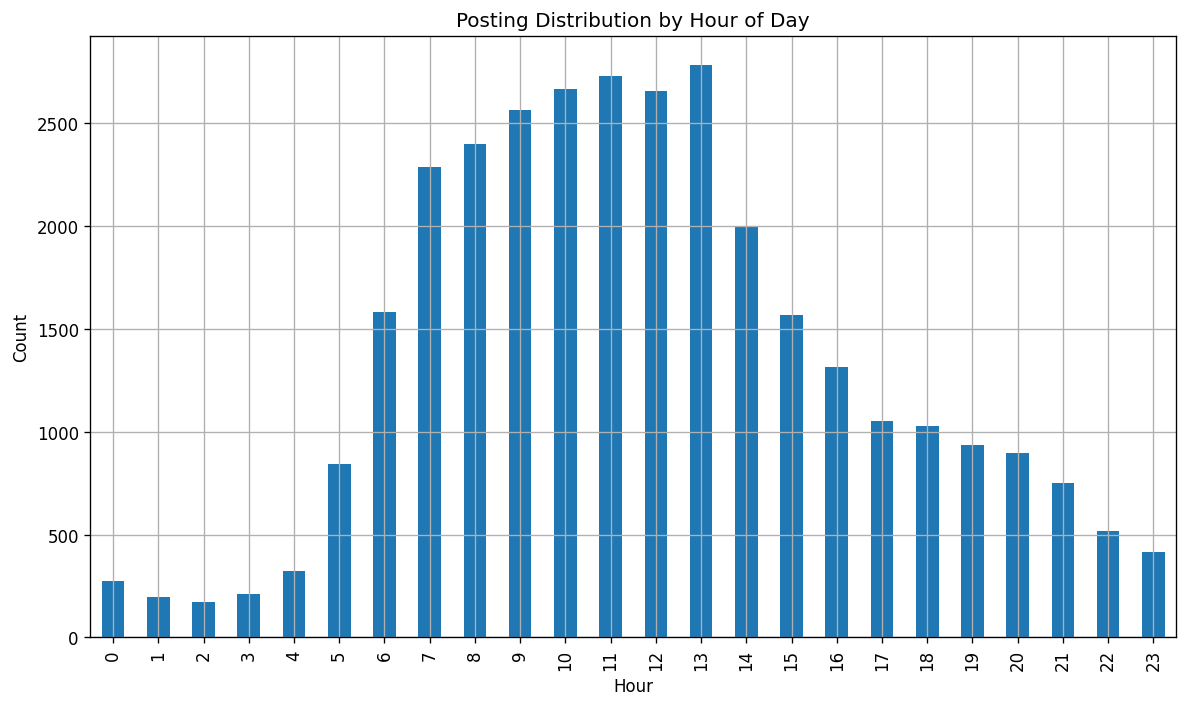

Saved: /Users/tiffanytseng/Documents/ai-review-moderation/reports/insights/hour_of_day_distribution.png


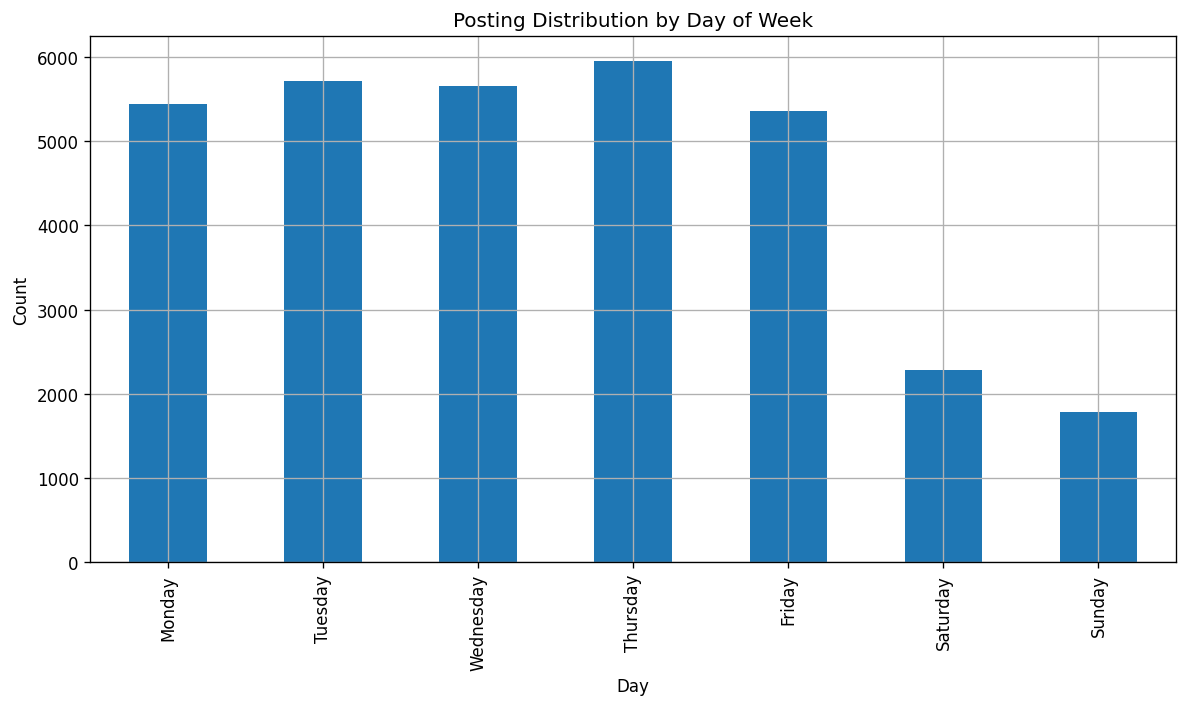

Saved: /Users/tiffanytseng/Documents/ai-review-moderation/reports/insights/day_of_week_distribution.png


In [12]:
# Hour of day histogram
ax = df["hour_of_day"].dropna().astype(int).value_counts().sort_index().plot(kind="bar")
ax.set_title("Posting Distribution by Hour of Day")
ax.set_xlabel("Hour")
ax.set_ylabel("Count")
plt.tight_layout()
out_path = REPORT_DIR / "hour_of_day_distribution.png"
plt.savefig(out_path)
plt.show()
print("Saved:", out_path)

# Day of week histogram
order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
day_counts = df["day_of_week"].value_counts()
day_counts = day_counts.reindex(order).fillna(0)

ax = day_counts.plot(kind="bar")
ax.set_title("Posting Distribution by Day of Week")
ax.set_xlabel("Day")
ax.set_ylabel("Count")
plt.tight_layout()
out_path = REPORT_DIR / "day_of_week_distribution.png"
plt.savefig(out_path)
plt.show()
print("Saved:", out_path)

# Save tables
df["hour_of_day"].value_counts().sort_index().to_csv(REPORT_DIR / "hour_of_day_counts.csv", header=["count"])
day_counts.to_csv(REPORT_DIR / "day_of_week_counts.csv", header=["count"])


In [14]:
df["reason"] = df["reason"].astype(str)
classes = sorted(df["reason"].unique().tolist())


In [15]:
# Compute top TF-IDF terms per reason
K = 15  # top-K terms per class
min_df = 5  # ignore very rare tokens
max_features = 30000

# Prepare corpus and labels
corpus = df["review_text"].tolist()
labels = df["reason"].tolist()
classes = sorted(df["reason"].unique().tolist())

# Vectorize
tfidf = TfidfVectorizer(
    lowercase=True,
    ngram_range=(1,2),
    min_df=min_df,
    max_features=max_features,
)
X = tfidf.fit_transform(corpus)
vocab = np.array(tfidf.get_feature_names_out())

# Aggregate TF-IDF by class (mean per-term across docs in that class)
rows = []
for cls in classes:
    idx = [i for i, y in enumerate(labels) if y == cls]
    if not idx:
        continue
    sub = X[idx]
    # Mean TF-IDF score for each term in this class
    mean_scores = np.asarray(sub.mean(axis=0)).ravel()
    top_idx = mean_scores.argsort()[::-1][:K]
    top_terms = vocab[top_idx]
    top_scores = mean_scores[top_idx]
    for t, s in zip(top_terms, top_scores):
        rows.append({"reason": cls, "term": t, "score": float(s)})

top_terms_df = pd.DataFrame(rows).sort_values(["reason","score"], ascending=[True, False])
top_terms_df.to_csv(REPORT_DIR / "top_terms_per_reason.csv", index=False)
top_terms_df.head(10)


,reason,term,score
0,12,zones,0.0
1,12,go the,0.0
2,12,go into,0.0
3,12,go live,0.0
4,12,go look,0.0
5,12,go off,0.0
6,12,go on,0.0
7,12,go out,0.0
8,12,go outside,0.0
9,12,go over,0.0


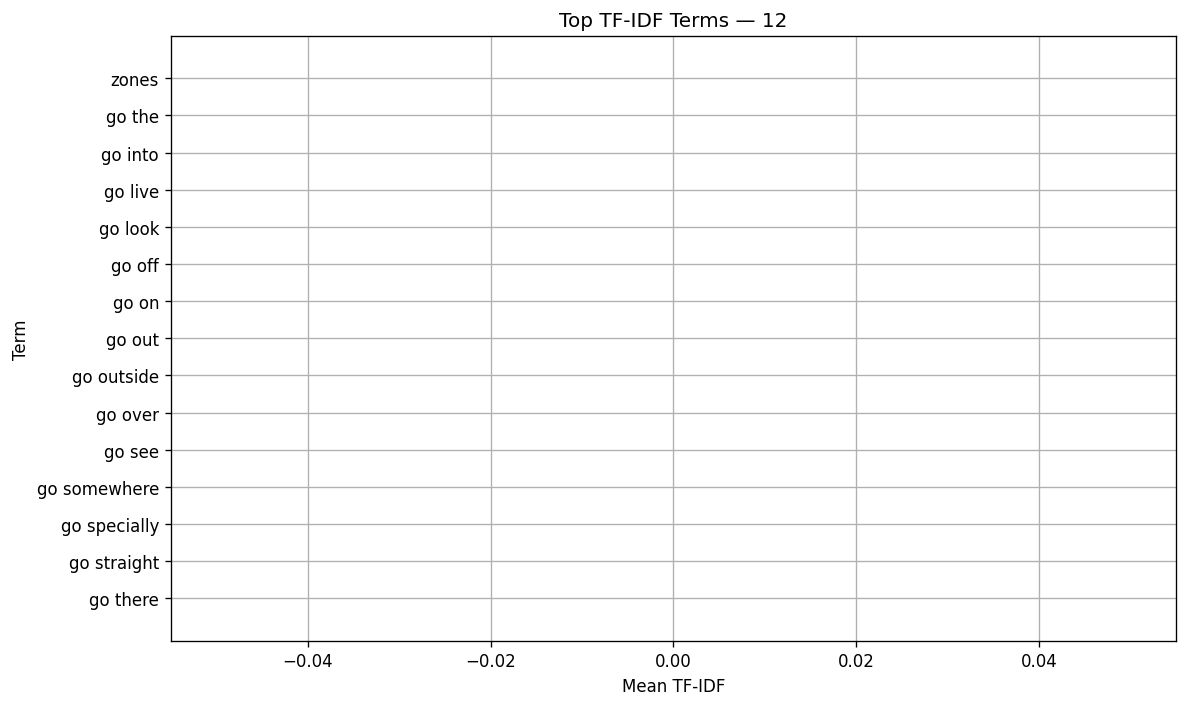

Saved: /Users/tiffanytseng/Documents/ai-review-moderation/reports/insights/top_terms_12.png


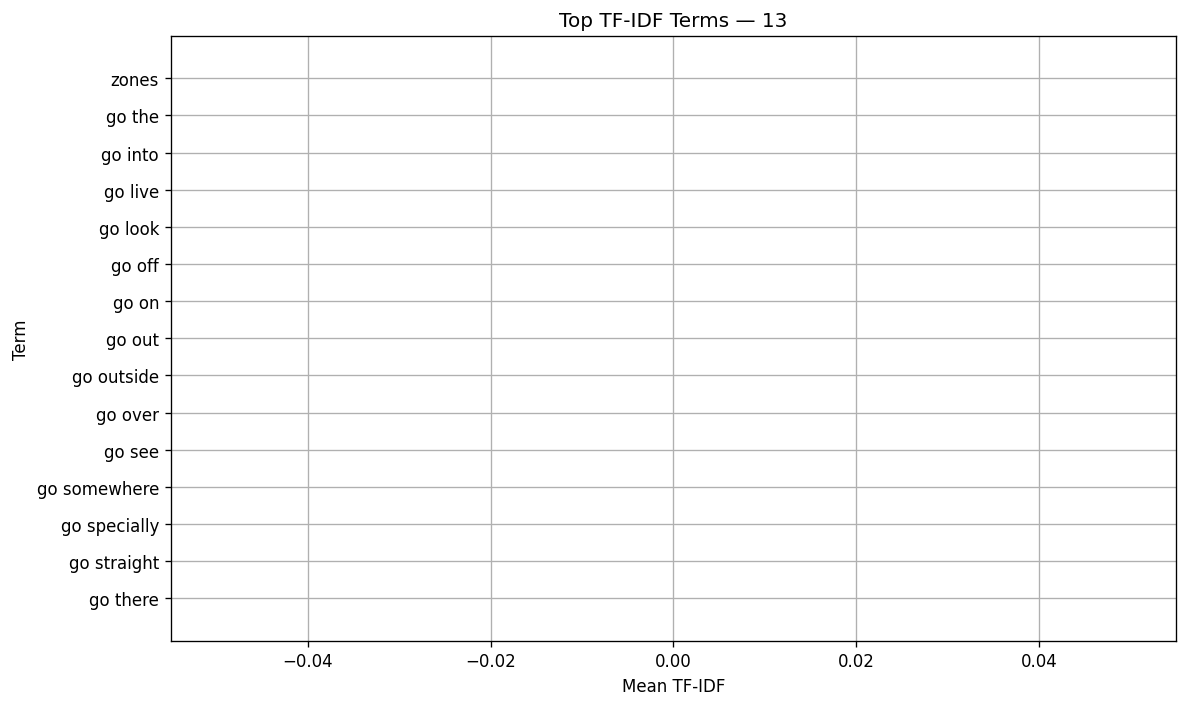

Saved: /Users/tiffanytseng/Documents/ai-review-moderation/reports/insights/top_terms_13.png


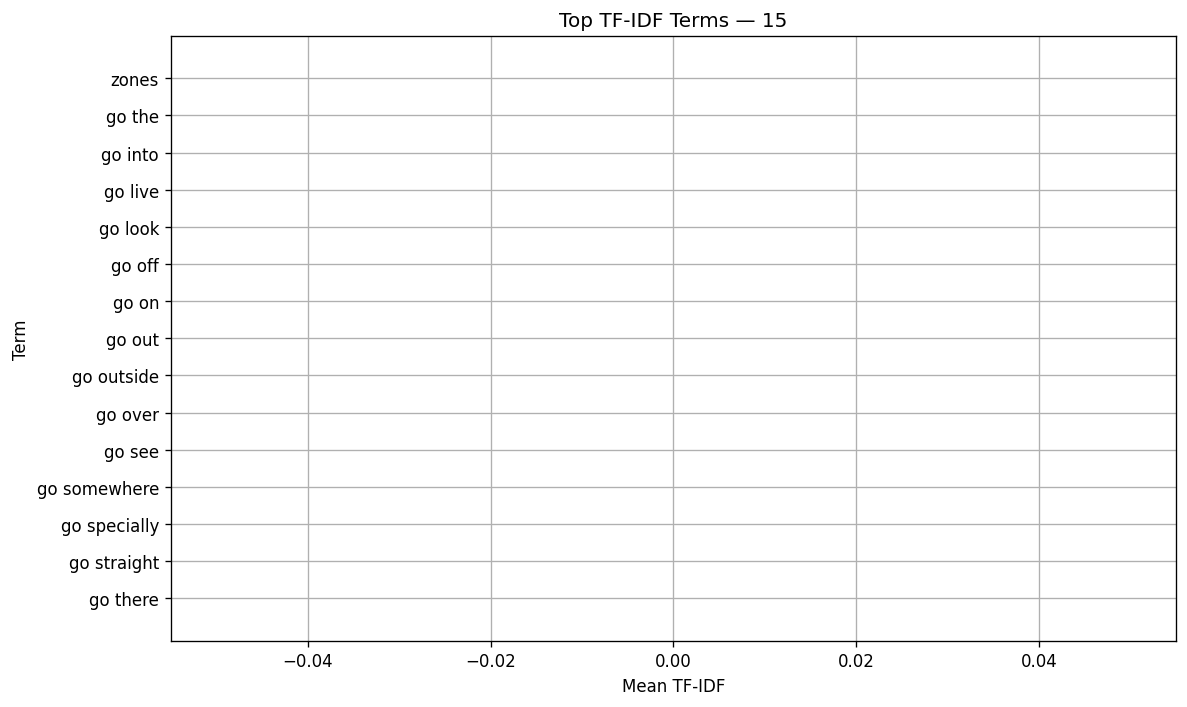

Saved: /Users/tiffanytseng/Documents/ai-review-moderation/reports/insights/top_terms_15.png


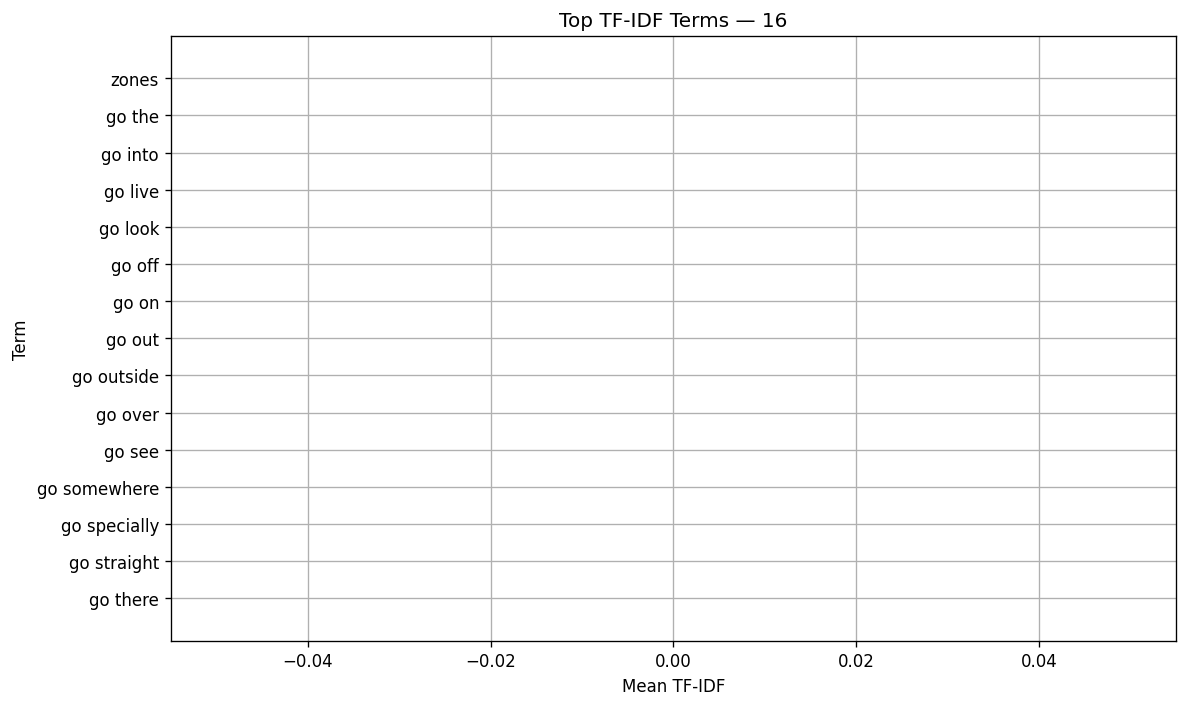

Saved: /Users/tiffanytseng/Documents/ai-review-moderation/reports/insights/top_terms_16.png


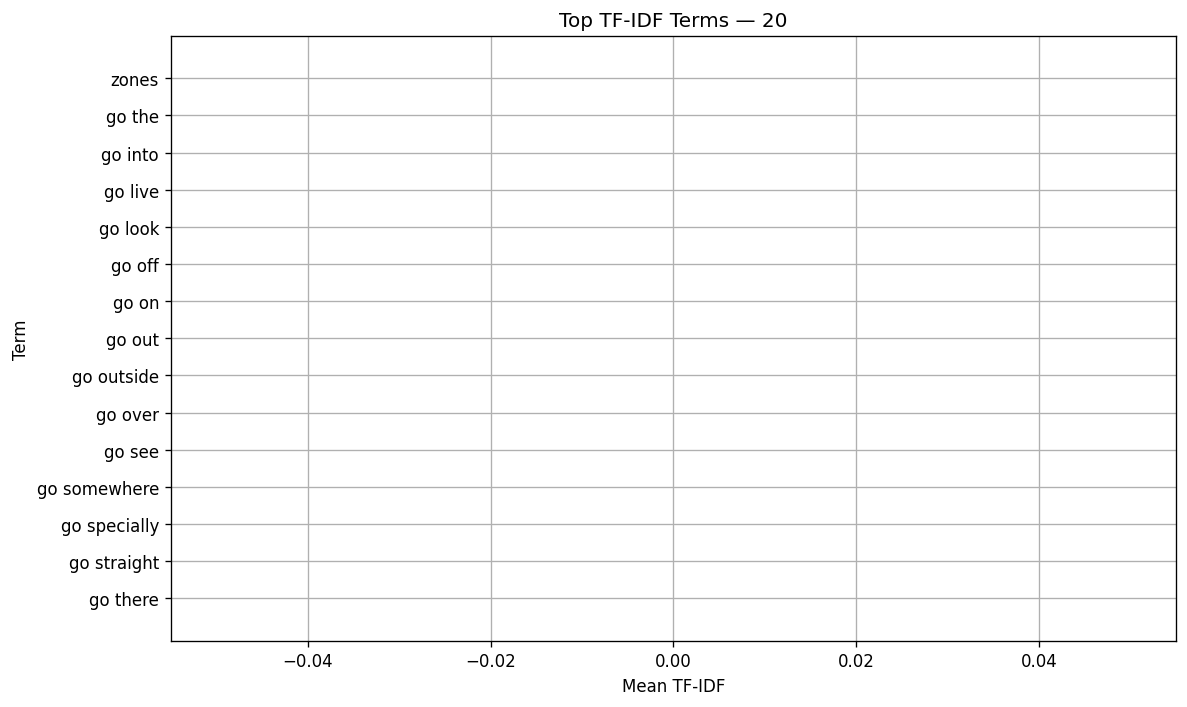

Saved: /Users/tiffanytseng/Documents/ai-review-moderation/reports/insights/top_terms_20.png


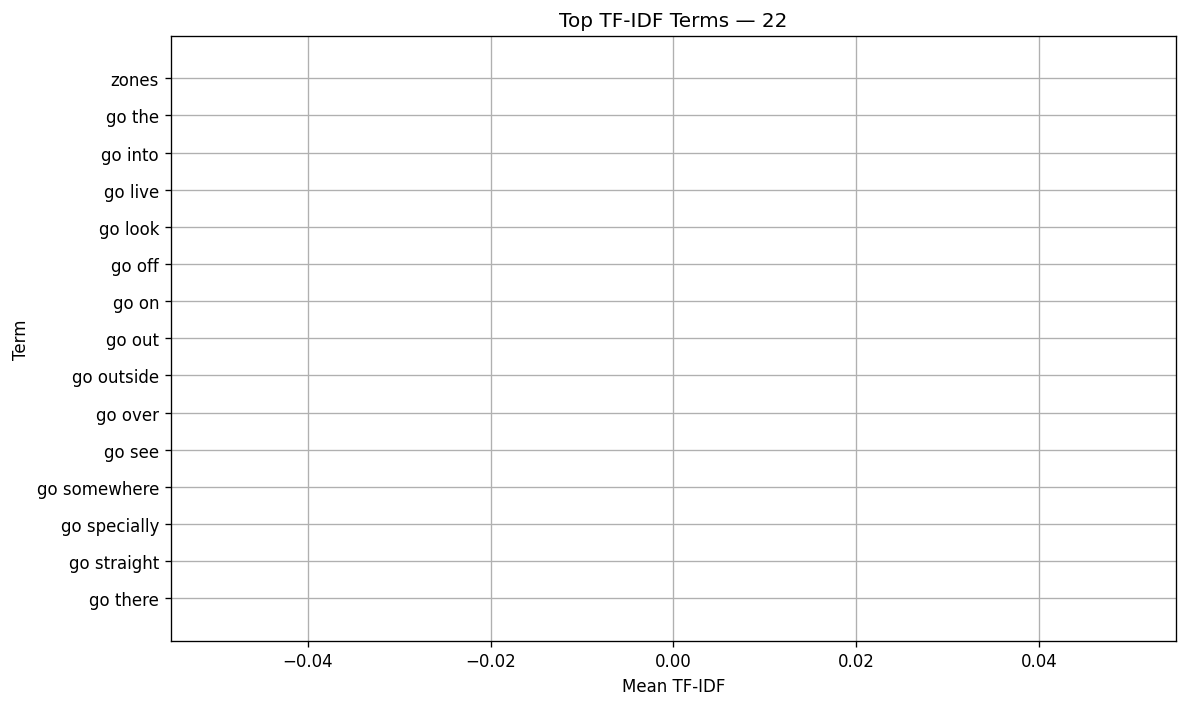

Saved: /Users/tiffanytseng/Documents/ai-review-moderation/reports/insights/top_terms_22.png


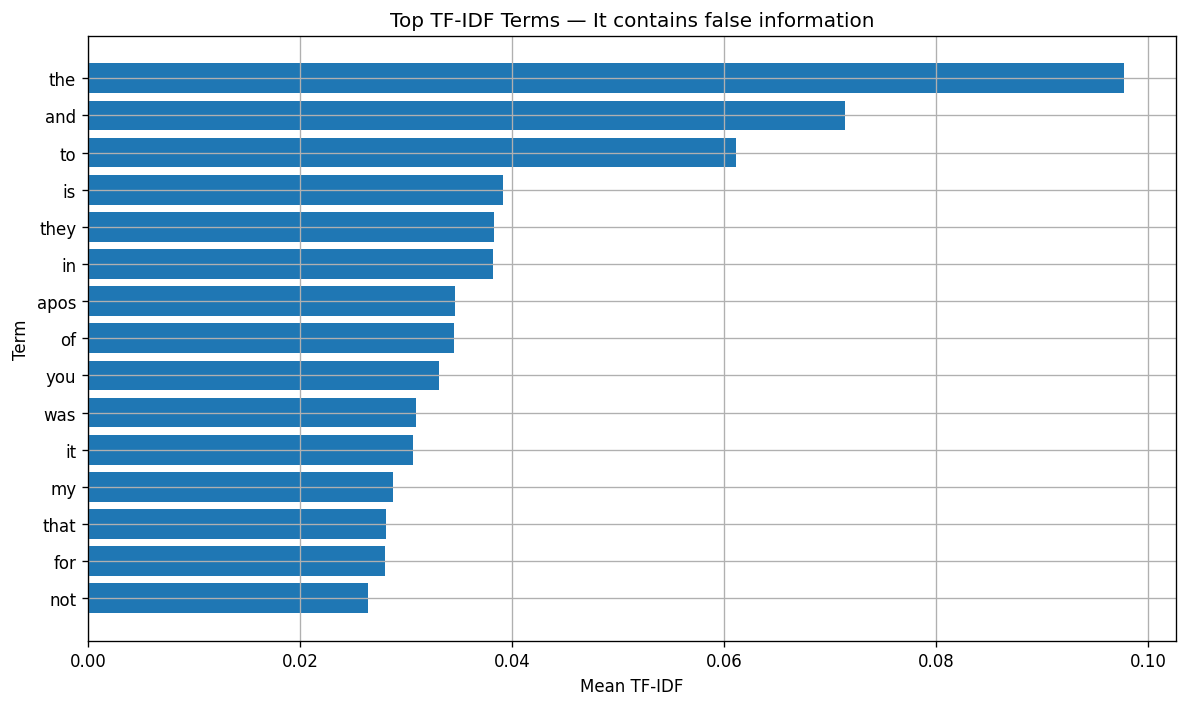

Saved: /Users/tiffanytseng/Documents/ai-review-moderation/reports/insights/top_terms_It_contains_false_information.png


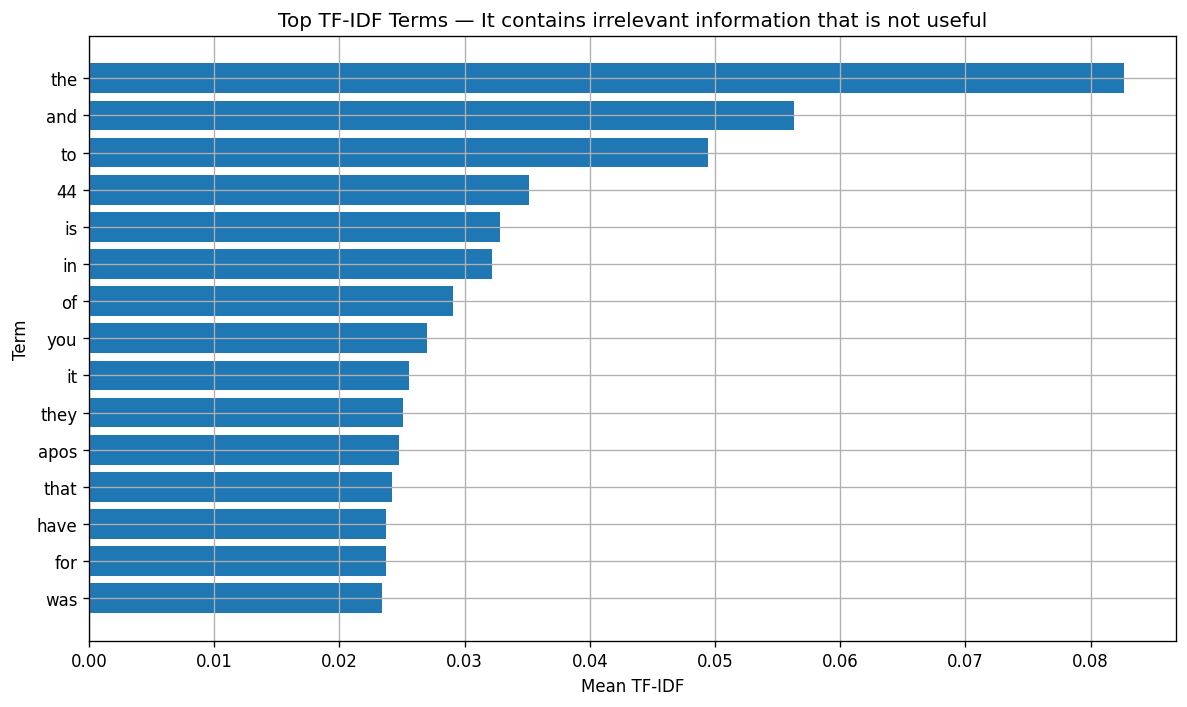

Saved: /Users/tiffanytseng/Documents/ai-review-moderation/reports/insights/top_terms_It_contains_irrelevant_information_that_is_not_useful.png


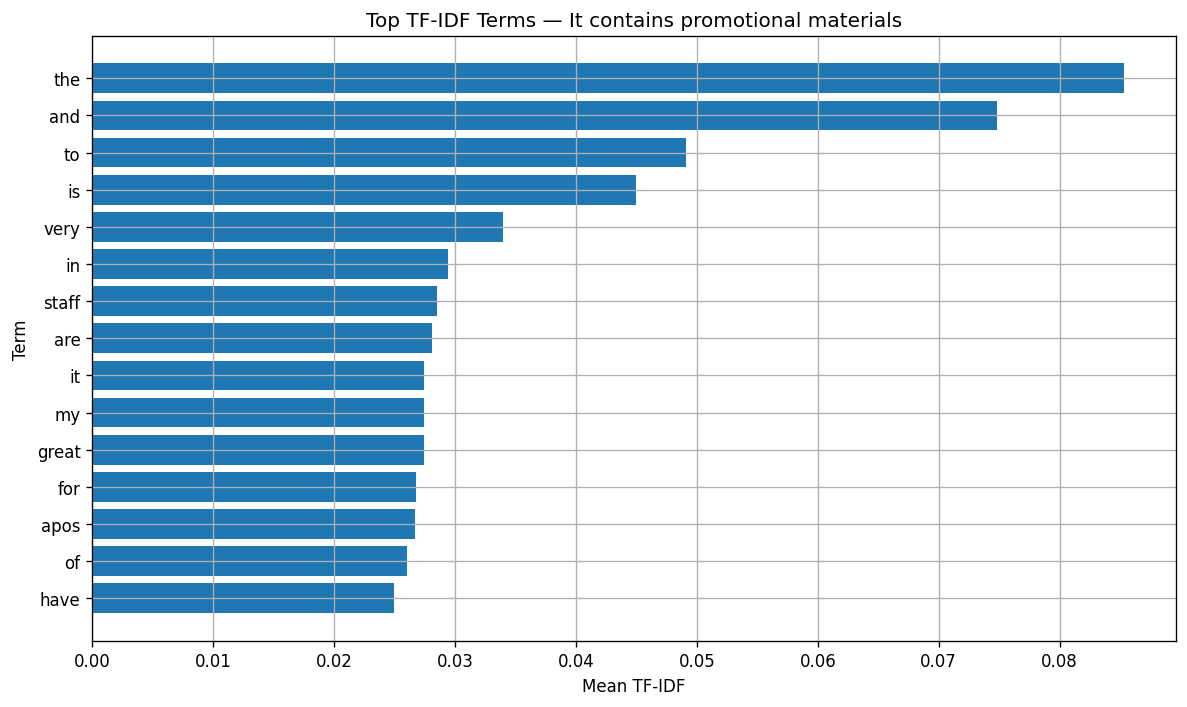

Saved: /Users/tiffanytseng/Documents/ai-review-moderation/reports/insights/top_terms_It_contains_promotional_materials.png


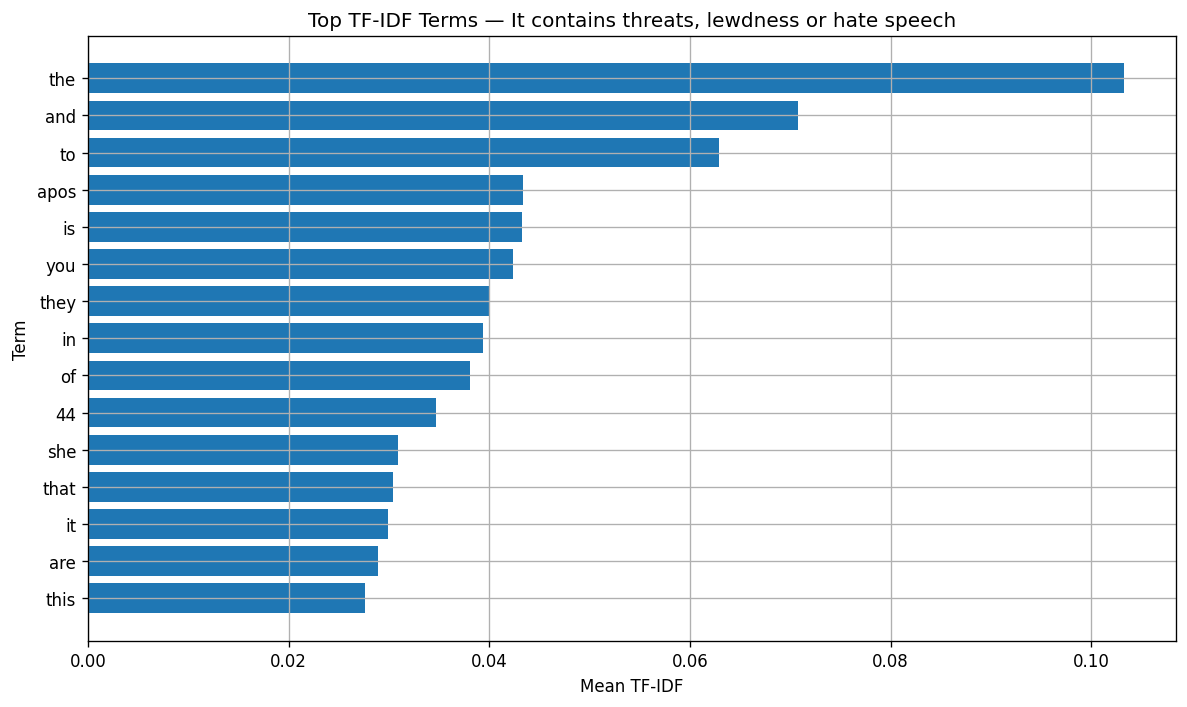

Saved: /Users/tiffanytseng/Documents/ai-review-moderation/reports/insights/top_terms_It_contains_threats,_lewdness_or_hate_speech.png


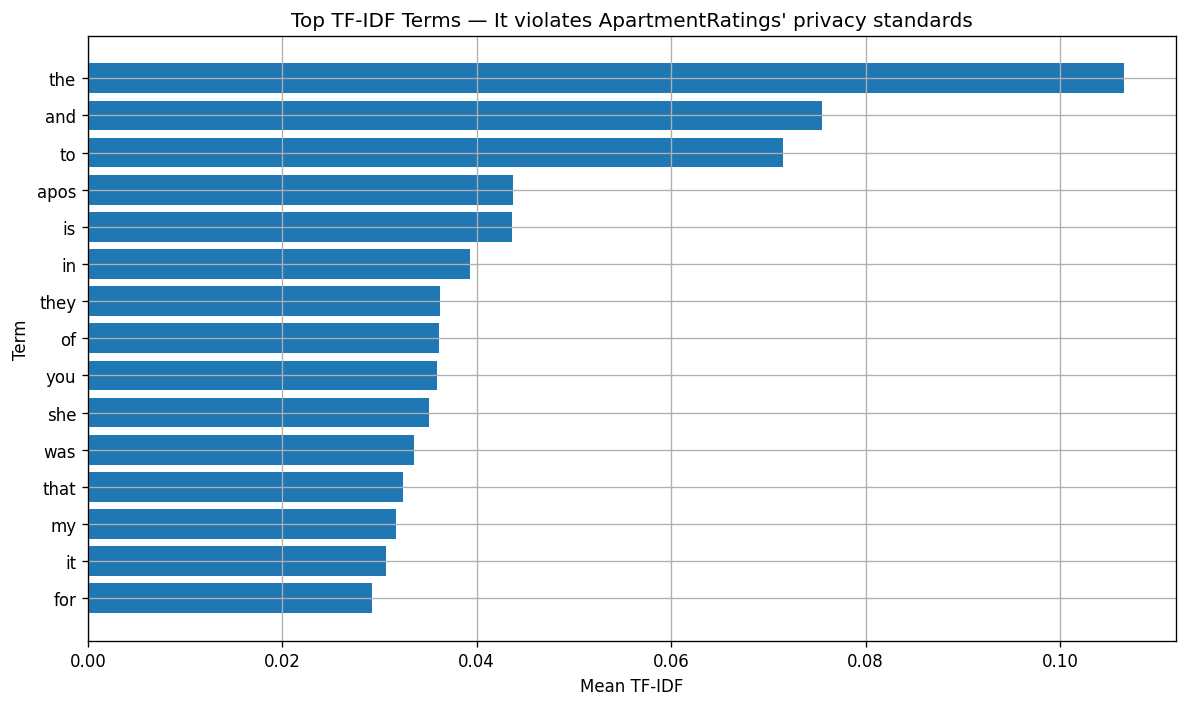

Saved: /Users/tiffanytseng/Documents/ai-review-moderation/reports/insights/top_terms_It_violates_ApartmentRatings'_privacy_standards.png


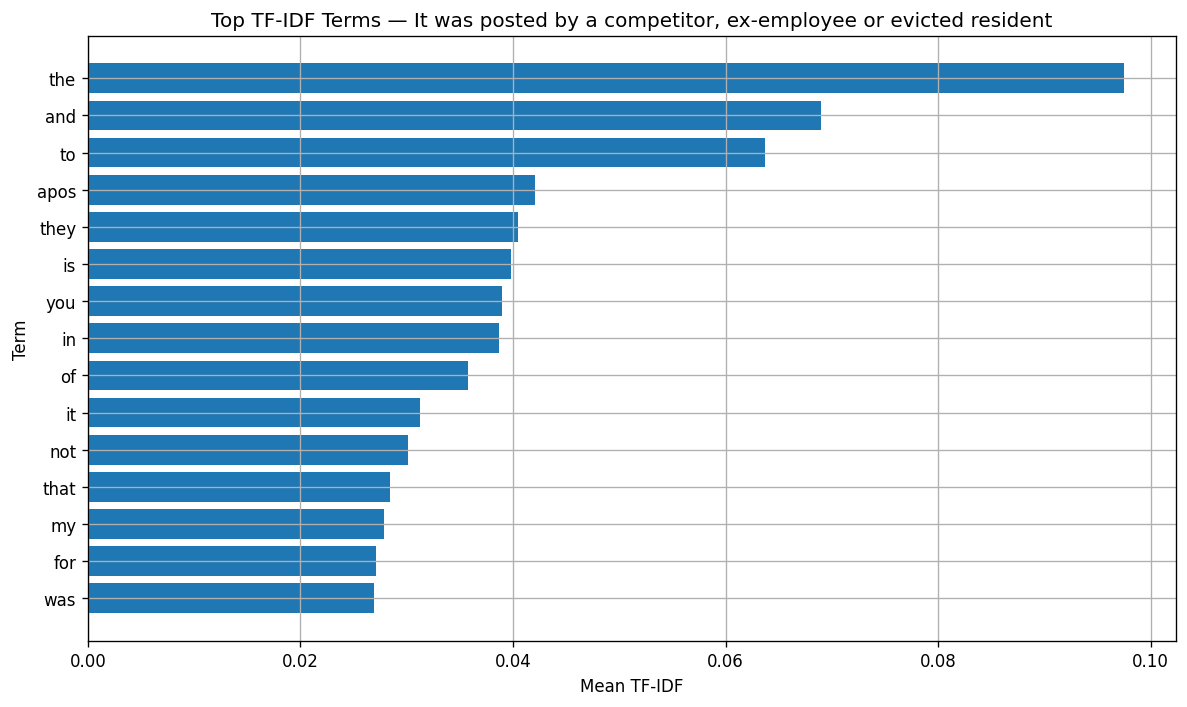

Saved: /Users/tiffanytseng/Documents/ai-review-moderation/reports/insights/top_terms_It_was_posted_by_a_competitor,_ex-employee_or_evicted_resident.png


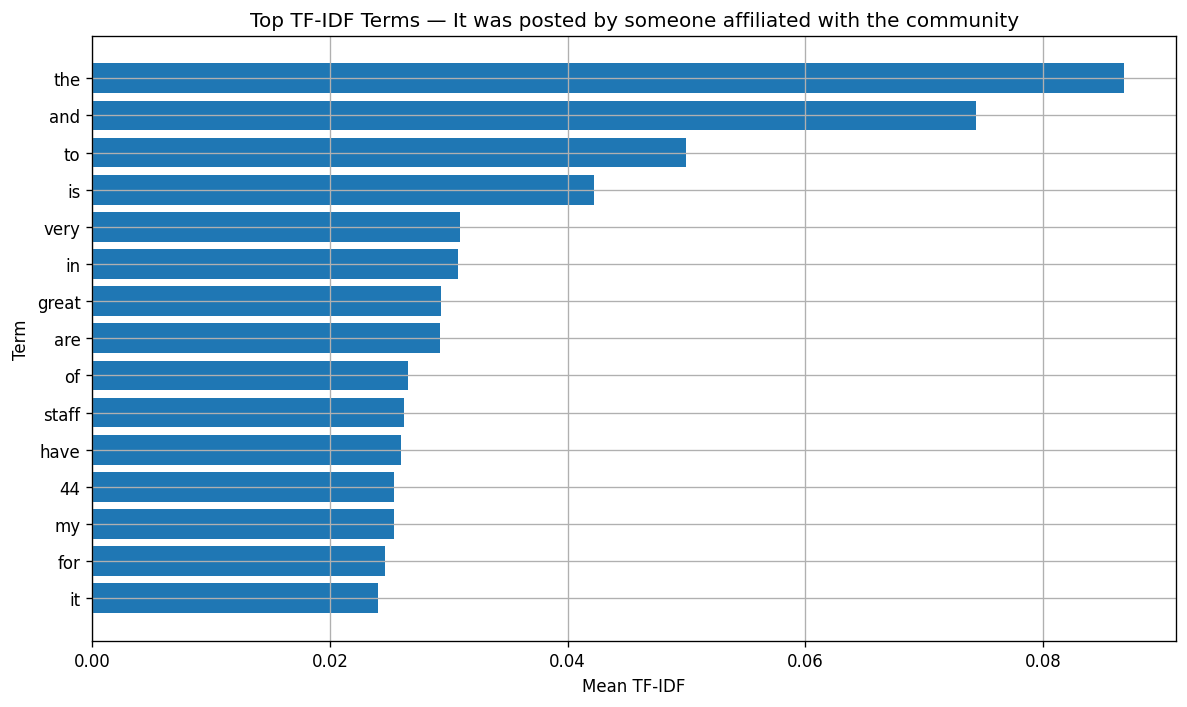

Saved: /Users/tiffanytseng/Documents/ai-review-moderation/reports/insights/top_terms_It_was_posted_by_someone_affiliated_with_the_community.png


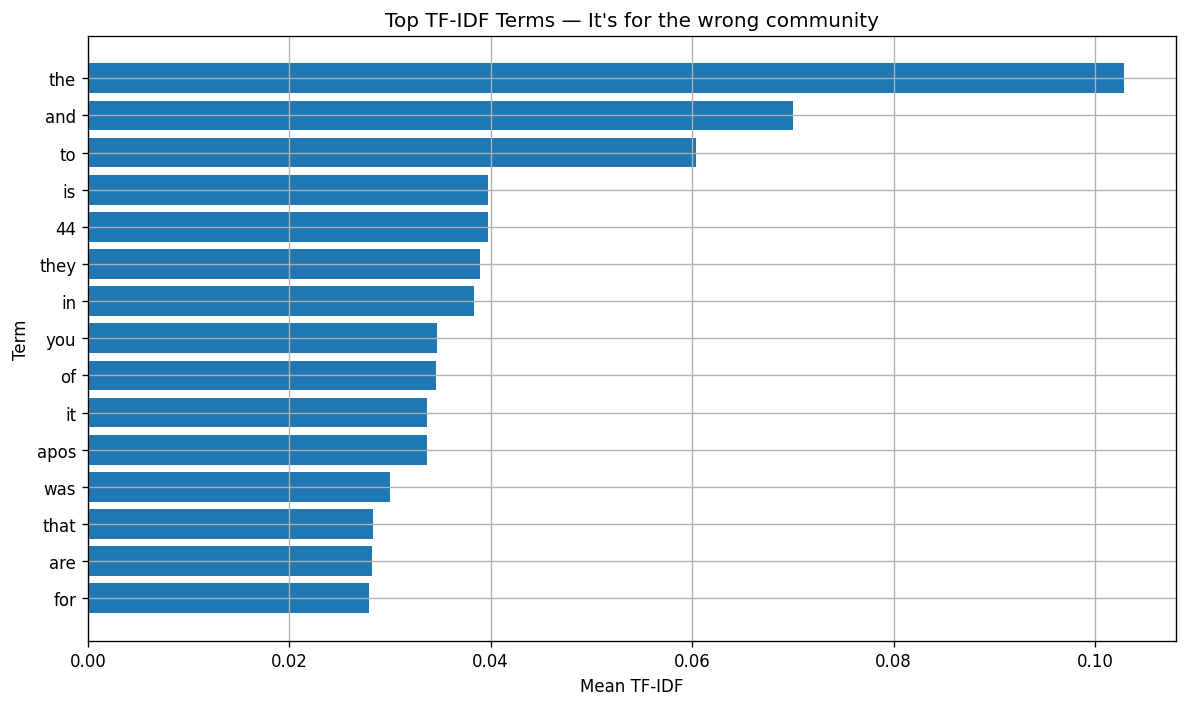

Saved: /Users/tiffanytseng/Documents/ai-review-moderation/reports/insights/top_terms_It's_for_the_wrong_community.png


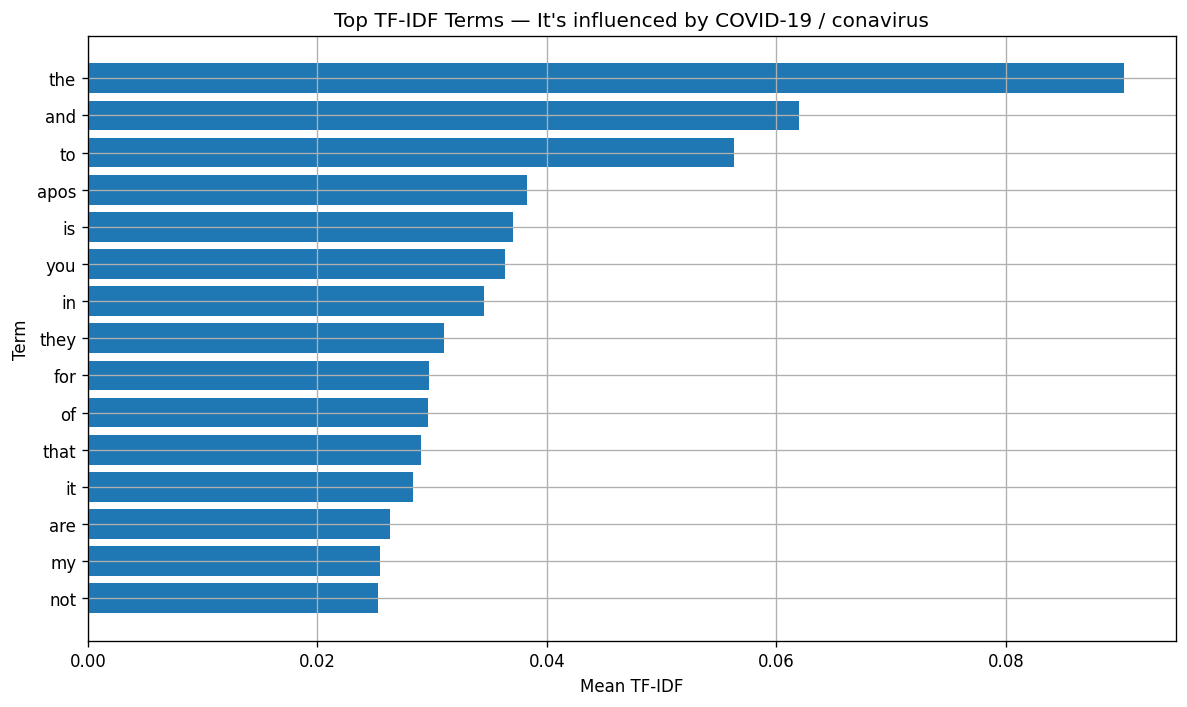

Saved: /Users/tiffanytseng/Documents/ai-review-moderation/reports/insights/top_terms_It's_influenced_by_COVID-19___conavirus.png


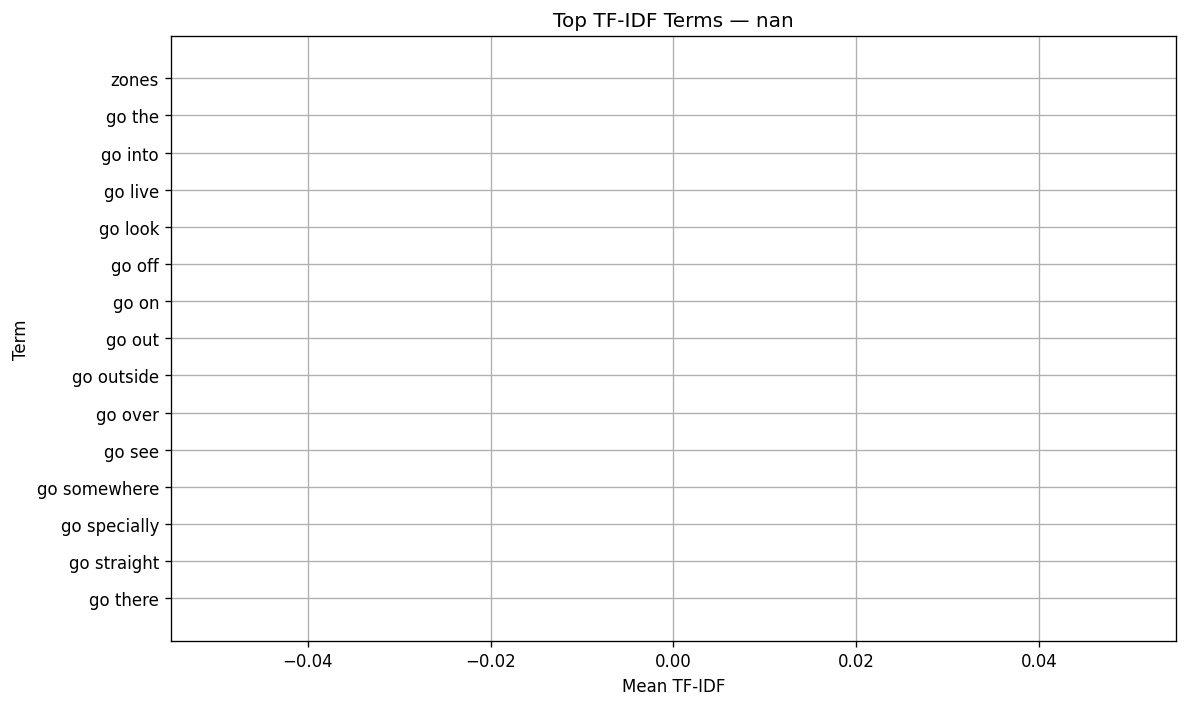

Saved: /Users/tiffanytseng/Documents/ai-review-moderation/reports/insights/top_terms_nan.png


In [16]:
# Plot small multiples: one bar chart per reason with top-K terms
unique_reasons = top_terms_df["reason"].unique().tolist()

for cls in unique_reasons:
    tmp = top_terms_df[top_terms_df["reason"] == cls].head(K)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(tmp["term"][::-1], tmp["score"][::-1])
    ax.set_title(f"Top TF-IDF Terms — {cls}")
    ax.set_xlabel("Mean TF-IDF")
    ax.set_ylabel("Term")
    plt.tight_layout()
    out_path = REPORT_DIR / f"top_terms_{cls.replace(' ','_').replace('/','_')}.png"
    plt.savefig(out_path)
    plt.show()
    print("Saved:", out_path)


In [17]:
# Heuristic: flag complexes with high count or high proportion of specific reasons
if "complex_id" in df.columns:
    agg = (
        df.groupby("complex_id")
          .agg(total=("review_text","count"))
          .sort_values("total", ascending=False)
          .reset_index()
    )

    # Per-reason distribution within complex
    crosstab = pd.crosstab(df["complex_id"], df["reason"], normalize="index")
    risky_cols = crosstab.columns.tolist()  # you can subset to a few sensitive reasons if needed
    risky = crosstab.copy()
    risky["total"] = agg.set_index("complex_id")["total"]
    # Score = weighted sum; here simply max proportion among reasons
    risky["risk_score"] = crosstab[risky_cols].max(axis=1)
    risky = risky.sort_values(["risk_score","total"], ascending=[False, False]).reset_index()

    top20 = risky.head(20)
    top20.to_csv(REPORT_DIR / "high_risk_complexes.csv", index=False)
    top20.head(10)
else:
    print("complex_id not found; skipping high-risk complexes table.")


In [18]:
# Generate a few ready-to-copy bullets for PM discussion
bullets = []

# 1) Top reasons
top3 = counts.head(3)
bullets.append(f"Top reasons by volume: {', '.join([f'{k} ({v})' for k,v in top3.items()])}.")

# 2) Time trend inflection (simple heuristic)
if len(pivot) >= 2:
    last = pivot.tail(1).sum(axis=1).item()
    prev = pivot.tail(2).head(1).sum(axis=1).item()
    change_pct = ((last - prev) / max(prev, 1)) * 100.0
    bullets.append(f"Month-over-month total volume change: {change_pct:+.1f}% (heuristic).")

# 3) Hours & days
h_peak = df["hour_of_day"].value_counts().idxmax()
d_peak = df["day_of_week"].value_counts().idxmax()
bullets.append(f"Peak posting hour: {h_peak}:00; Peak day: {d_peak}.")

# 4) Keyword hints for top class
if not top_terms_df.empty:
    first_cls = top_terms_df["reason"].iloc[0]
    sample_terms = top_terms_df[top_terms_df["reason"] == first_cls].head(5)["term"].tolist()
    bullets.append(f"Example top terms for '{first_cls}': {', '.join(sample_terms)}.")

# 5) High-risk complexes presence
if "complex_id" in df.columns and (REPORT_DIR / "high_risk_complexes.csv").exists():
    hr = pd.read_csv(REPORT_DIR / "high_risk_complexes.csv")
    if not hr.empty:
        bullets.append(f"High-risk complexes detected (top-1 by heuristic): {hr['complex_id'].iloc[0]} (risk_score {hr['risk_score'].iloc[0]:.2f}).")

# Save to a txt for quick copy
txt_path = REPORT_DIR / "pm_insights_bullets.txt"
with open(txt_path, "w") as f:
    for b in bullets:
        f.write("- " + b + "\n")

print("\n".join("- " + b for b in bullets))
print("Saved bullets to:", txt_path)


- Top reasons by volume: It contains false information (6794), It was posted by a competitor, ex-employee or evicted resident (6167), It contains threats, lewdness or hate speech (5546).
- Month-over-month total volume change: -99.1% (heuristic).
- Peak posting hour: 13.0:00; Peak day: Thursday.
- Example top terms for '12': zones, go the, go into, go live, go look.
- High-risk complexes detected (top-1 by heuristic): 317542053146226.0 (risk_score 1.00).
Saved bullets to: /Users/tiffanytseng/Documents/ai-review-moderation/reports/insights/pm_insights_bullets.txt


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# 各 reason 的數量分布
plt.figure(figsize=(8,4))
sns.countplot(y=df["reason"], order=df["reason"].value_counts().index)
plt.title("Class Distribution of Review Reasons")
plt.tight_layout()
plt.savefig("reports/insights/class_distribution.png")

# 時間趨勢圖
df["month"] = pd.to_datetime(df["date_created"]).dt.to_period("M")
monthly = df.groupby(["month","reason"]).size().reset_index(name="count")
top_reasons = df["reason"].value_counts().head(5).index
monthly = monthly[monthly["reason"].isin(top_reasons)]
plt.figure(figsize=(8,4))
sns.lineplot(data=monthly, x="month", y="count", hue="reason", marker="o")
plt.title("Monthly Trend of Top 5 Reasons")
plt.tight_layout()
plt.savefig("reports/insights/monthly_trend_topN.png")


ModuleNotFoundError: No module named 'seaborn'